# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from matplotlib.colors import Normalize
import networkx as nx
from scipy.signal import welch
import matplotlib.cm as cm
import seaborn as sns
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Utils

In [2]:
def scale_spectral_radius(W, target_radius=0.95):
    eigvals = np.linalg.eigvals(W)
    radius = np.max(np.abs(eigvals))
    if radius == 0:
        return W
    return (W / radius) * target_radius

In [3]:
def augment_state_with_squares(x):
    """
    Given state vector x in R^N, return [ x, x^2, 1 ] in R^(2N+1).
    We'll use this for both training and prediction.
    """
    x_sq = x**2
    return np.concatenate([x, x_sq, [1.0]])  # shape: 2N+1

In [ ]:
def plot_poincare_geodesic(p, q, ax, n_points=200, **kw):
    """
    Plot a geodesic between two points p and q on the Poincaré disk.
    
    Parameters:
    - p, q: np.array of shape (2,), points in the Poincaré disk
    - ax: matplotlib axis to plot on
    - n_points: number of points to use for the geodesic arc
    - **kw: keyword arguments passed to ax.plot
    
    Returns:
    - None, plots the geodesic on the given axis
    """
    
    # Ensure points are within the disk
    p_norm = np.linalg.norm(p)
    q_norm = np.linalg.norm(q)
    if p_norm >= 1.0 or q_norm >= 1.0:
        raise ValueError("Points must be within the unit disk")
    
    # Check if points are on a diameter (geodesic is a straight line)
    if np.isclose(np.linalg.norm(np.cross(np.append(p, 0), np.append(q, 0))), 0):
        ax.plot([p[0], q[0]], [p[1], q[1]], **kw)
        return
    
    # For non-diametric geodesics, we need to find the circle
    # orthogonal to the unit circle and passing through p and q
    
    # Möbius transformation approach
    x1, y1 = p
    x2, y2 = q
    
    # Calculate circle parameters
    # We're looking for a circle that is orthogonal to the unit circle
    # and passes through p and q
    
    # This is a circle with center c and radius r such that:
    # |c|^2 - r^2 = 1 (orthogonality condition)
    # |p - c|^2 = r^2 and |q - c|^2 = r^2 (p and q are on the circle)
    
    # Set up the linear system for finding the center
    A = np.array([
        [2*(x2 - x1), 2*(y2 - y1)],
        [2*x1, 2*y1]
    ])
    
    b = np.array([
        x2**2 + y2**2 - x1**2 - y1**2,
        1 + x1**2 + y1**2
    ])
    
    # Solve for the center c
    try:
        c = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        # If the system is singular, the points are on a straight line through the origin
        ax.plot([p[0], q[0]], [p[1], q[1]], **kw)
        return
    
    # Calculate radius
    r = np.sqrt(np.sum((p - c)**2))
    
    # Determine the angles for the arc
    theta1 = np.arctan2(p[1] - c[1], p[0] - c[0])
    theta2 = np.arctan2(q[1] - c[1], q[0] - c[0])
    
    # Ensure we take the shortest path (the arc that stays within the disk)
    # The key insight: we want the arc that stays inside the unit disk
    delta_theta = (theta2 - theta1) % (2 * np.pi)
    if delta_theta > np.pi:
        delta_theta = delta_theta - 2 * np.pi
    
    # If the center is far away, we might need to reverse the direction
    # to ensure we stay inside the unit disk
    mid_theta = theta1 + delta_theta/2
    mid_point = c + r * np.array([np.cos(mid_theta), np.sin(mid_theta)])
    if np.linalg.norm(mid_point) > 1:
        delta_theta = -delta_theta
    
    # Generate points along the arc
    thetas = np.linspace(theta1, theta1 + delta_theta, n_points)
    arc_points = c.reshape(2, 1) + r * np.vstack([np.cos(thetas), np.sin(thetas)])
    
    # Filter points to ensure they're within the unit disk
    mask = (arc_points[0]**2 + arc_points[1]**2) < 1 - 1e-10
    
    # Plot the geodesic arc
    ax.plot(arc_points[0, mask], arc_points[1, mask], **kw)
    
    return arc_points[:, mask]


In [ ]:
def plot_pca_projection3d(states):
    # Apply PCA for 3D visualization
    pca = PCA(n_components=3)
    proj = pca.fit_transform(states)

    sns.set_theme(style="white")
    fig = plt.figure(figsize=(12, 9))  # Increased width for padding
    ax = plt.axes(projection='3d')

    # Scatter plot
    p = ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], 
                   c=np.arange(len(proj)), cmap='viridis', s=2.5)

    # Axis labels with padding
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    cbar = fig.colorbar(p, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label("Index progression")
    
    plt.savefig('Figures/PCA_projection_2d_rossler_Poincare.png', dpi=600)
    plt.show()

In [ ]:
def plot_pca_projection2d(states):
    # Apply PCA for 3D visualization
    pca = PCA(n_components=2)
    proj = pca.fit_transform(states)

    sns.set_theme(style="white")
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    p = ax.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap='plasma', s=2.5)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    plt.savefig('Figures/PCA_projection_3d_rossler_Poincare.png', dpi=600)
    plt.show()

In [8]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

def visualize_sparsity(matrix1, matrix2):
        combined = np.stack([matrix1, matrix2])
        min_nonzero = np.min(combined[combined > 0])
        small_value = min_nonzero / 1000
        vmax = np.max(combined)
        norm = colors.LogNorm(vmin=small_value, vmax=vmax)

        # Setup figure and gridspec
        fig = plt.figure(figsize=(20, 8))
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.05)

        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])
        cbar_ax = plt.subplot(gs[2])  # This will span the full vertical height

        # Plot first matrix
        sns.heatmap(matrix1, cmap='twilight', ax=ax1, norm=norm, mask=(matrix1 == 0), cbar=False)
        ax1.axis('off')

        # Plot second matrix
        sns.heatmap(matrix2, cmap='twilight', ax=ax2, norm=norm, mask=(matrix2 == 0),
                        cbar=True, cbar_ax=cbar_ax)
        ax2.axis('off')
        plt.savefig('Figures/Sparsity Visualization.png', dpi=600)
        plt.show()

In [9]:
def create_delay_embedding(signal, embed_dim):
    L = len(signal) - embed_dim + 1
    emb = np.zeros((L, embed_dim))
    for i in range(L):
        emb[i, :] = signal[i:i+embed_dim]
    return emb

# Baselines

### Baseline ESN

In [16]:
class BaselineESN3D:
    """
    A baseline Echo State Network that handles:
        - 3D input (x,y,z)
        - 3D output (x(t+1), y(t+1), z(t+1))"
    """
    def __init__(self,
                 reservoir_size=400,
                 spectral_radius=0.95,
                 connectivity=0.1,
                 input_scale=1.0,
                 leaking_rate=0.8,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        np.random.seed(self.seed)
        # Initialize W with small random values (mean=0, variance=0.01)
        W = np.random.randn(reservoir_size, reservoir_size) * 0.1
        # Create a boolean sparsity mask
        mask = (np.random.rand(reservoir_size, reservoir_size) < self.connectivity)
        W = W * mask
        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 100)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()

    def reset_state(self):
        self.x = np.zeros(self.reservoir_size)

    def _apply_activation(self, act_type, val):
        return np.tanh(val)
        # if act_type=='tanh':
        #     return np.tanh(val)
        # elif act_type=='relu':
        #     return max(0.0, val)
        # elif act_type=='sin':
        #     return np.sin(val)
        # elif act_type=='linear':
        #     return val
        # else:
        #     return np.tanh(val)

    def _update(self, u):
        """
        x(t+1) = (1-alpha)*x(t) + alpha*[ node-by-node activation( W*x(t)+W_in*u ) ]
        """
        pre_activations = self.W @ self.x + self.W_in @ u
        x_new = np.zeros_like(self.x)
        for i in range(self.reservoir_size):
            activation = self.node_activations[i]
            x_new[i] = self._apply_activation(activation, pre_activations[i])
        alpha = self.leaking_rate
        self.x = (1.0 - alpha)*self.x + alpha*x_new
        
    def collect_states(self, inputs, discard=100):
        """
        Run reservoir on 'inputs' (shape [T, 3]), discarding the first 'discard' steps.
        Returns: states [T-discard, reservoir_size]
        """
        self.reset_state()
        states = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]
    

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Teacher forcing for single-step:
            - input(t) = [x(t), y(t), z(t)]
            - target(t) = [x(t+1), y(t+1), z(t+1)]
        We collect states(t), then solve a multi-output linear ridge regression:
            W_out * [x(t); 1] ~ target(t+1).
        For quadratic readout:
            W_out * [x(t); x²(t); 1] ~ target(t+1).
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]  # shape [T-discard, 3]

        # Augment states with bias
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0], 1))])  # shape [T-discard, N+1]

        # Quadratic readout
        # Build augmented matrix [ x, x^2, 1 ]
        X_list = []
        for s in states_use:
            X_list.append( np.concatenate([s, s**2, [1.0]]) )
        X_aug = np.array(X_list)                                # shape [T-discard, 2N+1]

        ridge_reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        ridge_reg.fit(X_aug, targets_use)
        self.W_out = ridge_reg.coef_

    def predict(self, inputs):
        """
        Single-step-ahead inference on test data:
        For each inputs[t], we update reservoir, then read out 3D prediction.
        """
        preds = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([self.x, (self.x)**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)
    
    def autoregressive_predict(self, initial_input, num_steps):
        """
        Autoregressive multi-step forecasting for num_steps
        """
        preds = []
        current_input = initial_input.copy()
      
        for _ in range(num_steps):
            self._update(current_input)
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([self.x, (self.x)**2, [1.0]])  # For quadratic readout
            out = self.W_out @ x_aug
            preds.append(out)
            current_input = out
        
        return np.array(preds)

### SCR

In [11]:
class CycleReservoir3D(BaselineESN3D):
    """
    Cyclic Reservoir for 3D -> 3D Lorenz.
    - reservoir_size, spectral_radius, input_scale, leaking_rate, ridge_alpha as in baseline
    """
    def __init__(self,
                 reservoir_size=400,
                 spectral_radius=0.95,
                 cycle_weight = 0.8,
                 input_scale=1.0,
                 leaking_rate=0.8,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):
        
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.cycle_weight = cycle_weight
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        np.random.seed(self.seed)
        # Build cycle adjacency: W[i,(i+1)%N] = 1
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            j = (i+1) % reservoir_size
            W[i, j] = cycle_weight

        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed + 100)
        # Initialize input weights in range [-input_scale, input_scale]
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()


### CRJ

In [12]:
class CRJRes3D(BaselineESN3D):
    def __init__(self,
                 reservoir_size=300,
                 edge_weight = 0.8,
                 jump=10,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):
        
        self.reservoir_size = reservoir_size
        self.edge_weight = edge_weight
        self.jump = jump
        self.spectral_radius = spectral_radius
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        np.random.seed(self.seed)
        W = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            W[i, (i+1) % reservoir_size] = edge_weight              # Cycle edge
            W[i, (i + self.jump) % reservoir_size] = edge_weight    # Jump edge

        W = scale_spectral_radius(W, self.spectral_radius)
        self.W = W

        np.random.seed(self.seed+100)
        self.W_in = (np.random.rand(self.reservoir_size, 3) - 0.5) * 2.0 * self.input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        # Readout: shape (3, reservoir_size+1) -> 3D output
        self.W_out = None
        self.reset_state()

### Small-World Res

In [13]:
class SWRes3D(BaselineESN3D):
    """
    Small-World (SW) Reservoir for 3D->3D single-step prediction using the Watts-Strogatz (WS) method.
    """
    def __init__(self,
                 reservoir_size=300,
                 rewiring_prob=0.1,
                 degree=6,
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):

        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.rewiring_prob = rewiring_prob
        self.degree = degree
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        np.random.seed(self.seed)
        # Create a Watts-Strogatz small-world graph
        ws_graph = nx.watts_strogatz_graph(n=reservoir_size, k=self.degree, p=self.rewiring_prob, seed=self.seed)
        adjacency_matrix = nx.to_numpy_array(ws_graph)
        
        # Initialize reservoir weights
        W = adjacency_matrix * np.random.uniform(-1, 1, (reservoir_size, reservoir_size))
        W = scale_spectral_radius(W, spectral_radius)
        self.W = W

        np.random.seed(self.seed+100)
        self.W_in = (np.random.rand(reservoir_size, 3) - 0.5) * 2.0 * input_scale

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)

        self.W_out = None
        self.reset_state()

### MCI-ESN

In [14]:
class MCIESN3D:
    def __init__(self,
                 reservoir_size=300,
                 cycle_weight=0.8,
                 connect_weight=0.8,
                 combine_factor=0.5,
                 v1=0.6,
                 v2=0.6,
                 spectral_radius=0.95,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42
                 ):
        self.reservoir_size = reservoir_size
        self.cycle_weight = cycle_weight
        self.connect_weight = connect_weight
        self.combine_factor = combine_factor
        self.v1 = v1
        self.v2 = v2
        self.spectral_radius = spectral_radius
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed = seed

        np.random.seed(self.seed)
        W_res = np.zeros((reservoir_size, reservoir_size))
        for i in range(reservoir_size):
            j = (i+1) % reservoir_size
            W_res[j, i] = self.cycle_weight

        W_res = scale_spectral_radius(W_res, spectral_radius)
        self.W_res = W_res                      # shared by both sub-reservoirs

        np.random.seed(self.seed + 100)
        W_cn = np.zeros((reservoir_size, reservoir_size))
        W_cn[0, reservoir_size-1] = self.connect_weight
        W_cn[reservoir_size-1, 0] = self.connect_weight
        self.W_cn = W_cn

        np.random.seed(self.seed+200)

        sign_V1 = np.random.choice([-1, 1], size=(reservoir_size, 3))
        sign_V2 = np.random.choice([-1, 1], size=(reservoir_size, 3))

        V1 = self.v1 * sign_V1
        V2 = self.v2 * sign_V2

        self.W_in1 = V1 - V2
        self.W_in2 = V1 + V2
        
        self.W_out = None

    def reset_state(self):
        self.x1 = np.zeros(self.reservoir_size)
        self.x2 = np.zeros(self.reservoir_size)

    def _update(self, u):
        """
        Single-step reservoir update.
        x1(t+1) = cos( Win1*u(t+1) + W_res*x1(t) + W_cn*x2(t) )
        x2(t+1) = sin( Win2*u(t+1) + W_res*x2(t) + W_cn*x1(t) )
        Then x(t+1)= h*x1(t+1) + (1-h)* x2(t+1).
        """
        # pre activation for reservoir1
        pre_activation1 = self.W_in1 @ u + self.W_res @ self.x1 + self.W_cn @ self.x2
        # reservoir1 uses cos
        x1_new = np.cos(pre_activation1)

        # reservoir2 uses sin
        pre_activation2 = self.W_in2 @ u + self.W_res @ self.x2 + self.W_cn @ self.x1
        x2_new = np.sin(pre_activation2)

        alpha = self.leaking_rate
        self.x1 = (1.0 - alpha)*self.x1 + alpha*x1_new
        self.x2 = (1.0 - alpha)*self.x2 + alpha*x2_new

    def _combine_state(self):
        """
        Combine x1(t), x2(t) => x(t) = h*x1(t) + (1-h)*x2(t)
        """
        h = self.combine_factor
        return h*self.x1 + (1.0 - h)*self.x2
    
    def collect_states(self, inputs, discard=100):
        self.reset_state()
        states = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            combined = self._combine_state()
            states.append(combined.copy())
        states = np.array(states)
        return states[discard:], states[:discard]
    
    def fit_readout(self, train_input, train_target, discard=100):
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]

        # Augment states with bias
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0], 1))])  # shape [T-discard, N+1]

        # Quadratic readout
        # Build augmented matrix [ x, x^2, 1 ]
        X_list = []
        for s in states_use:
            X_list.append( np.concatenate([s, s**2, [1.0]]) )
        X_aug = np.array(X_list)                                # shape [T-discard, 2N+1]

        ridge_reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        ridge_reg.fit(X_aug, targets_use)
        self.W_out = ridge_reg.coef_

    def predict(self, inputs):
        preds = []
        for t in range(len(inputs)):
            self._update(inputs[t])
            combined = self._combine_state()
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([combined, combined**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)
    
    def autoregressive_predict(self, initial_input, num_steps):
        preds = []
        current_input = initial_input.copy()
      
        for _ in range(num_steps):
            self._update(current_input)
            combined = self._combine_state()
            # x_aug = np.concatenate([self.x, [1.0]])
            x_aug = np.concatenate([combined, combined**2, [1.0]])  # For quadratic readout
            out = self.W_out @ x_aug
            preds.append(out)
            current_input = out
        
        return np.array(preds)

### DeepESN

In [15]:
class DeepESN3D:
    """
    Deep Echo State Network (DeepESN) for multi-layered reservoir computing.
    Each layer has its own reservoir, and the states are propagated through layers.
    """

    def __init__(self,
                 num_layers=3,
                 reservoir_size=100,
                 spectral_radius=0.95,
                 connectivity=0.1,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 activation_choices=('tanh','relu','sin','linear'),
                 seed=42):
        """
        Parameters:
        - num_layers: Number of reservoir layers.
        - reservoir_size: Number of neurons in each reservoir layer.
        """
        self.num_layers = num_layers
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.input_scale = input_scale
        self.leaking_rate = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.activation_choices = activation_choices
        self.seed = seed

        # Initialize reservoirs and input weights for each layer
        self.reservoirs = []
        self.input_weights = []
        self.states = []

        np.random.seed(self.seed)
        for layer in range(num_layers):
            np.random.seed(seed + layer)
            W = np.random.randn(reservoir_size, reservoir_size) * 0.1
            mask = (np.random.rand(reservoir_size, reservoir_size) < self.connectivity)
            W = W * mask
            W = scale_spectral_radius(W, spectral_radius)
            self.reservoirs.append(W)

            if layer == 0 : 
                W_in = (np.random.rand(reservoir_size, 3) - 0.5) * 2.0 * input_scale
            else:
                W_in = (np.random.rand(reservoir_size, reservoir_size) - 0.5) * 2.0 * input_scale
            self.input_weights.append(W_in)

        np.random.seed(self.seed + 200)
        self.node_activations = np.random.choice(self.activation_choices, size=self.reservoir_size)
        
        self.W_out = None
        self.reset_state()

    def reset_state(self):
        """
        Reset the states of all reservoir layers.
        """
        self.states = [np.zeros(self.reservoir_size) for _ in range(self.num_layers)]

    def _apply_activation(self, act_type, val):
        return np.tanh(val)
        # if act_type=='tanh':
        #     return np.tanh(val)
        # elif act_type=='relu':
        #     return max(0.0, val)
        # elif act_type=='sin':
        #     return np.sin(val)
        # elif act_type=='linear':
        #     return val
        # else:
        #     return np.tanh(val)

    def _update_layer(self, layer_idx, u):
        """
        Update a single reservoir layer.
        """
        pre_activation = self.reservoirs[layer_idx] @ self.states[layer_idx]
        if layer_idx == 0:
            pre_activation += self.input_weights[layer_idx] @ u
        else:
            pre_activation += self.input_weights[layer_idx] @ self.states[layer_idx - 1]

        x_new = np.zeros_like(pre_activation)
        for i in range(self.reservoir_size):
            activation = self.node_activations[i]
            x_new[i] = self._apply_activation(activation, pre_activation[i])
        alpha = self.leaking_rate
        self.states[layer_idx] = (1.0 - alpha) * self.states[layer_idx] + alpha * x_new

    def collect_states(self, inputs, discard=100):
        self.reset_state()
        all_states = []
        for u in inputs:
            for layer_idx in range(self.num_layers):
                self._update_layer(layer_idx, u)
            all_states.append(np.concatenate(self.states))
        all_states = np.array(all_states)
        return all_states[discard:], all_states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Train the readout layer using ridge regression.
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]

        # Augment states with bias
        # X_aug = np.hstack([states_use, np.ones((states_use.shape[0], 1))])  # shape [T-discard, N*L+1]

        # Quadratic readout
        # Build augmented matrix [ x, x^2, 1 ]
        X_list = []
        for s in states_use:
            X_list.append( np.concatenate([s, s**2, [1.0]]) )
        X_aug = np.array(X_list)                                    # shape [T-discard, 2N*L+1]

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict(self, inputs):
        """
        Single-step-ahead inference on test data.
        """
        preds = []
        for u in inputs:
            for layer_idx in range(self.num_layers):
                self._update_layer(layer_idx, u)
            state = np.concatenate(self.states)
            # x_aug = np.concatenate([state, [1.0]])
            x_aug = np.concatenate([state, (state)**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
        return np.array(preds)

    def autoregressive_predict(self, initial_input, num_steps):
        """
        Autoregressive multi-step forecasting for num_steps
        """
        preds = []
        current_input = initial_input.copy()

        for _ in range(num_steps):
            for layer_idx in range(self.num_layers):
                self._update_layer(layer_idx, current_input)
            state = np.concatenate(self.states)
            # x_aug = np.concatenate([state, [1.0]])
            x_aug = np.concatenate([state, (state)**2, [1.0]])  # For quadrartic readout
            out = self.W_out @ x_aug
            preds.append(out)
            current_input = out
        
        return np.array(preds)

# Poincare Section Reservoirs

In [17]:
class PoincareSectionRes3D(BaselineESN3D):
    """
    Poincaré Section Reservoir for 3D chaotic systems.

    Steps:
      1) We define a plane in R^3 by (n dot x) = delta => crossing events.
      2) We find the crossing times in the given trajectory => crossing points in R^3 => project onto a 2D coordinate in the plane.
      3) We cluster those 2D points into M cells => build adjacency from consecutive visits => row-normalize => scale => W in R^(M x M).
      4) W_in in R^(M x 3) is random. We define a standard leaky ESN update x(t+1) = (1-alpha)*x(t) + alpha*tanh( W*x(t) + W_in*u(t) ).
      5) We gather states with teacher forcing => polynomial readout => solve => W_out => 3D output.
      6) For prediction, feed back our own output as input.

    This approach encodes the system's discrete return-map structure on the chosen plane, but we embed it in a continuous reservoir for next-step modeling.
    It's purely data-driven, relying on the observed 3D trajectory.
    """

    def __init__(self,
                 normal_vec = np.array([0, 0, 1]),  # normal to the plane
                 delta      = 25.0,                # plane eq: <normal, x> = delta
                 M=50,                              # # of clusters in the plane
                 spectral_radius=0.95,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 seed=42):
        """
        Parameters
        ----------
        normal_vec     : shape (3,), normal to the plane
        delta          : plane eq => <normal_vec, x> = delta
        M              : number of clusters for the crossing points in the plane
        spectral_radius: final adjacency scale
        input_scale    : scale factor for W_in
        leaking_rate   : ESN leaky alpha
        ridge_alpha    : readout ridge penalty
        seed           : random seed
        """
        self.normal_vec     = normal_vec / np.linalg.norm(normal_vec)
        self.delta          = delta
        self.M              = M
        self.spectral_radius= spectral_radius
        self.input_scale    = input_scale
        self.leaking_rate   = leaking_rate
        self.ridge_alpha    = ridge_alpha
        self.seed           = seed

        # We'll build adjacency W, input matrix W_in, readout W_out, state x
        self.W       = None
        self.W_in    = None
        self.W_out   = None
        self.x       = None

        # We'll store a plane basis to map R^3 => R^2
        self.plane_basis = None

    def _find_plane_basis(self):
        """
        Finds two orthonormal vectors in the plane that is orthonormal to self.normal_vec.
        We'll project crossing points onto those vectors to get 2D coords.
        """
        n = self.normal_vec
        # find any vector v not parallel to n
        # a simple approach: pick e_x or e_y or e_z and check if near parallel
        # or do a random approach
        if abs(n[0]) < 0.9:
            v = np.array([1,0,0], dtype=float)
        else:
            v = np.array([0,1,0], dtype=float)
        # remove component parallel to n => v' = v - (v.n)*n
        v_orth = v - np.dot(v,n)*n
        v_orth = v_orth / np.linalg.norm(v_orth)
        # second basis vector is cross(n, v_orth)
        w = np.cross(n, v_orth)
        w = w / np.linalg.norm(w)
        self.plane_basis = np.stack([v_orth, w], axis=1)  # shape (3,2)

    def _project_3d_to_plane(self, x_3d):
        """
        x_3d: shape (3,)
        returns shape (2,) => coords in plane spanned by plane_basis.
        """
        # plane_basis: shape (3,2). Multiply => x_2d = plane_basis^T * x_3d
        return self.plane_basis.T @ x_3d

    def _check_crossing(self, x_prev, x_curr):
        """
        Checks if the line segment [x_prev, x_curr] crosses the plane <n, x> = delta.
        Return (True, crossing_point_in_3d) or (False, None).
        We'll do a simple approach: 
          f(x) = <n, x> - delta
          we check signs of f(x_prev) and f(x_curr). If sign changes, we do linear interpolation.
        """
        n = self.normal_vec
        f_prev = np.dot(n, x_prev) - self.delta
        f_curr = np.dot(n, x_curr) - self.delta
        if f_prev == 0.0:
            # exactly on plane
            return (True, x_prev)
        if f_curr == 0.0:
            return (True, x_curr)
        if f_prev * f_curr > 0.0:
            # same sign => no crossing
            return (False, None)
        # else sign changed => crossing
        # do linear interpolation param s in [0,1]
        # x_cross = x_prev + s*(x_curr - x_prev) => f(x_cross) = 0
        # => dot(n, x_prev + s*(x_curr - x_prev)) = delta
        # => dot(n, x_prev) + s * dot(n, x_curr - x_prev) = delta
        denom = np.dot(n, (x_curr - x_prev))
        s = (self.delta - np.dot(n, x_prev)) / denom
        x_cross = x_prev + s*(x_curr - x_prev)
        return (True, x_cross)

    def _collect_poincare_crossings(self, data_3d):
        """
        data_3d: shape [T, 3].
        We'll find all segments that cross the plane => store crossing points.
        Returns a list of crossing points in R^3 in chronological order.
        """
        T = len(data_3d)
        crossings = []
        for t in range(T-1):
            x_prev = data_3d[t]
            x_curr = data_3d[t+1]
            crossed, x_cross = self._check_crossing(x_prev, x_curr)
            if crossed:
                crossings.append(x_cross)
        return np.array(crossings)  # shape [Nc, 3]

    def _build_adjacency_from_crossings(self, plane_points):
        """
        plane_points: shape [Nc, 2], successive crossing points in 2D plane coords.
        We'll do k-means => M clusters => build T in R^(M x M) from consecutive visits => row-norm => scale.
        Returns W => shape (M, M).
        """
        km = KMeans(n_clusters=self.M, random_state=self.seed)
        km.fit(plane_points)  # shape [Nc, 2]
        c_assign = km.predict(plane_points)

        # build transition counts
        T_mat = np.zeros((self.M, self.M))
        for k in range(len(c_assign)-1):
            i = c_assign[k]
            j = c_assign[k+1]
            T_mat[i,j] += 1

        # row normalize
        row_sum = T_mat.sum(axis=1, keepdims=True)
        row_sum[row_sum==0.0] = 1.0
        T_mat = T_mat / row_sum

        # scale spectral radius
        T_mat = scale_spectral_radius(T_mat, self.spectral_radius)
        return T_mat

    def reset_state(self):
        """Reset the internal reservoir state x in R^M."""
        if self.x is not None:
            self.x.fill(0.0)

    def _update(self, u):
        """
        ESN update:
          x(t+1) = (1 - alpha)*x(t) + alpha*tanh( W x(t) + W_in u(t) ).
        """
        alpha = self.leaking_rate
        pre_acts = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_acts)
        self.x = (1.0 - alpha)*self.x + alpha*x_new

    def collect_states(self, inputs, discard=100):
        """
        Teacher-forcing => feed real 3D => gather states => shape => [T-discard, M].
        Returns (states_after_discard, states_discarded).
        """
        self.reset_state()
        states = []
        for val in inputs:
            self._update(val)
            states.append(self.x.copy())
        states = np.array(states)
        return states[discard:], states[:discard]

    def fit_readout(self, train_input, train_target, discard=100):
        """
        1) find plane crossings => project => cluster => adjacency => scale => W
        2) define random W_in => shape(M, 3)
        3) teacher forcing => polynomial readout => solve => W_out
        """
        # step 0) define plane basis for 2D projection
        self._find_plane_basis()

        # step 1) find plane crossings => shape [Nc, 3]
        crossing_3d = self._collect_poincare_crossings(train_input)
        if len(crossing_3d) < 2:
            # no or minimal crossing => fallback
            print("Warning: No (or too few) plane crossings found => trivial adjacency.")
            self.W = np.zeros((self.M, self.M))
            self.W_in = np.zeros((self.M, 3))
            self.x = np.zeros(self.M)
            # We won't fail => but the reservoir won't do anything interesting
        else:
            # project crossing_3d => shape [Nc, 2]
            plane_2d = []
            for p in crossing_3d:
                plane_2d.append(self._project_3d_to_plane(p))
            plane_2d = np.array(plane_2d)

            # step 2) build adjacency => shape (M, M)
            T_mat = self._build_adjacency_from_crossings(plane_2d)
            self.W = T_mat

            # step 3) define random W_in => shape(M, 3)
            np.random.seed(self.seed)
            self.W_in = (np.random.rand(self.M,3)-0.5)*2.0*self.input_scale

            # define x => R^M
            self.x = np.zeros(self.M)

        # gather states => teacher forcing => polynomial => readout
        states_use, _ = self.collect_states(train_input, discard=discard)
        target_use = train_target[discard:]
        X_list = []
        for s in states_use:
            X_list.append( augment_state_with_squares(s) )
        X_aug = np.array(X_list)

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, target_use)
        self.W_out = reg.coef_

    


# Datasets

### Lorenz System Data Generation

In [18]:
def lorenz_derivatives(state, t, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """Compute time derivatives [dx/dt, dy/dt, dz/dt] for the Lorenz system."""
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [19]:
def generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=25.0,
    dt=0.01,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
):
    """
    Numerically integrate Lorenz equations x'(t), y'(t), z'(t) using odeint.
    Returns: 
       t_vals: array of time points
       sol   : array shape [num_steps, 3] of [x(t), y(t), z(t)]
    """
    num_steps = int(tmax / dt)
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(lorenz_derivatives, initial_state, t_vals, args=(sigma, rho, beta))
    return t_vals, sol

### Rossler System Data Generation

In [20]:
def rossler_derivatives(state, t, a=0.2, b=0.2, c=5.7):
    """Compute time derivatives [dx/dt, dy/dt, dz/dt] for the Rössler system."""
    x, y, z = state
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

In [21]:
def generate_rossler_data(
    initial_state=[1.0, 0.0, 0.0],
    tmax=25.0,
    dt=0.01,
    a=0.2,
    b=0.2,
    c=5.7
):
    """
    Numerically integrate Rössler equations x'(t), y'(t), z'(t) using odeint.
    Returns: 
       t_vals: array of time points
       sol   : array shape [num_steps, 3] of [x(t), y(t), z(t)]
    """
    num_steps = int(tmax / dt)
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(rossler_derivatives, initial_state, t_vals, args=(a, b, c))
    return t_vals, sol

### Chen System Data Generation

In [22]:
def chen_derivatives(state, t, a=35.0, b=3.0, c=28.0):
    """
    Computes time derivatives [dx/dt, dy/dt, dz/dt] for the Chen system.
    """
    x, y, z = state
    dxdt = a*(y - x)
    dydt = (c - a)*x + c*y - x*z
    dzdt = x*y - b*z
    return [dxdt, dydt, dzdt]

In [23]:
def generate_chen_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=50.0,
    dt=0.01,
    a=35.0,
    b=3.0,
    c=28.0
):
    """
    Numerically integrate Chen equations x'(t), y'(t), z'(t) using odeint.
    Returns: 
       t_vals: array of time points
       sol   : array shape [num_steps, 3] of [x(t), y(t), z(t)]
    """
    num_steps = int(tmax / dt)
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(chen_derivatives, initial_state, t_vals, args=(a, b, c))
    return t_vals, sol

### Chua System Data Generation

In [24]:
def chua_derivatives(state, t, alpha, beta, m0, m1):
    """
    Computes time derivatives [dx/dt, dy/dt, dz/dt] for the Chua system.
    """
    x, y, z = state

    # Nonlinear function h(x)
    h = m1 * x + 0.5 * (m0 - m1) * (np.abs(x + 1) - np.abs(x - 1))

    dxdt = alpha * (y - x - h)
    dydt = x - y + z
    dzdt = -beta * y

    return [dxdt, dydt, dzdt]

In [25]:
def generate_chua_data(
    initial_state=[0.1, 0.0, 0.0],
    tmax=100.0,
    dt=0.01,
    alpha=15.6,
    beta=28.0,
    m0=-1.143,
    m1=-0.714
):
    """
    Numerically integrate Chua's circuit equations.
    Returns:
        t_vals: array of time points
        sol   : array shape [num_steps, 3] of [x(t), y(t), z(t)]
    """
    num_steps = int(tmax / dt)
    t_vals = np.linspace(0, tmax, num_steps)
    sol = odeint(chua_derivatives, initial_state, t_vals, args=(alpha, beta, m0, m1))
    return t_vals, sol

# Metrics

### NRMSE

In [27]:
def evaluate_nrmse(all_preds, test_target, horizons):
    """
    Evaluate model performance over multiple prediction horizons for Teacher-forced Single-step Forecasting
    """
    horizon_nrmse = {}
    
    for horizon in horizons:
        preds = all_preds[:horizon]
        targets = test_target[:horizon]
        squared_errors = (preds - targets)**2
        variance = np.var(targets, axis=0)
        nrmse = np.sqrt(np.sum(squared_errors) / (horizon * variance))
        horizon_nrmse[horizon] = nrmse

    return horizon_nrmse

### VPT

In [28]:
def compute_valid_prediction_time(y_true, y_pred, test_time, lyapunov_time, threshold=0.4):
    y_mean = np.mean(y_true, axis=0)
    y_centered = y_true - y_mean
    denom = np.mean(np.sum(y_centered**2, axis=1))

    error = y_true - y_pred
    squared_error = np.sum(error**2, axis=1)
    delta = squared_error / denom

    idx_exceed = np.where(delta > threshold)[0]
    if len(idx_exceed) == 0:
        # never exceeds threshold => set T_VPT to the final time
        T_VPT = test_time[-1]
    else:
        T_VPT = test_time[idx_exceed[0]]

    ratio = T_VPT / lyapunov_time

    return T_VPT, ratio

### ADev

In [29]:
def compute_attractor_deviation(predictions, targets, cube_size=(0.1, 0.1, 0.1)):
    """
    Compute the Attractor Deviation (ADev) metric.

    Parameters:
        predictions (numpy.ndarray): Predicted trajectories of shape (n, 3).
        targets (numpy.ndarray): True trajectories of shape (n, 3).
        cube_size (tuple): Dimensions of the cube (dx, dy, dz).

    Returns:
        float: The ADev metric.
    """
    # Define the cube grid based on the range of the data and cube size
    min_coords = np.min(np.vstack((predictions, targets)), axis=0)
    max_coords = np.max(np.vstack((predictions, targets)), axis=0)

    # Create a grid of cubes
    grid_shape = ((max_coords - min_coords) / cube_size).astype(int) + 1

    # Initialize the cube occupancy arrays
    pred_cubes = np.zeros(grid_shape, dtype=int)
    target_cubes = np.zeros(grid_shape, dtype=int)

    # Map trajectories to cubes
    pred_indices = ((predictions - min_coords) / cube_size).astype(int)
    target_indices = ((targets - min_coords) / cube_size).astype(int)

    # Mark cubes visited by predictions and targets
    for idx in pred_indices:
        pred_cubes[tuple(idx)] = 1
    for idx in target_indices:
        target_cubes[tuple(idx)] = 1

    # Compute the ADev metric
    adev = np.sum(np.abs(pred_cubes - target_cubes))
    return adev

### PSD

In [30]:
def compute_psd(y, dt=0.01):
    z = y[:, 2]  # Extract Z-component
    
    # Compute PSD using Welch’s method
    freqs, psd = welch(z, fs=1/dt, window='hamming', nperseg=len(z))  # Using Hamming window
    
    return freqs, psd


# Dataset Preparation

### Lorenz System

In [31]:
tmax = 240.0
dt = 0.02
lorenz_t_vals, lorenz_trajectory = generate_lorenz_data(
    initial_state=[1.0, 1.0, 1.0], 
    tmax=tmax,
    dt=dt,
    sigma=10.0,
    rho=28.0,
    beta=8.0/3.0
)

# Discard first 2,000 points as washout
washout = 2000
lorenz_t_vals = lorenz_t_vals[washout:]
lorenz_trajectory = lorenz_trajectory[washout:]

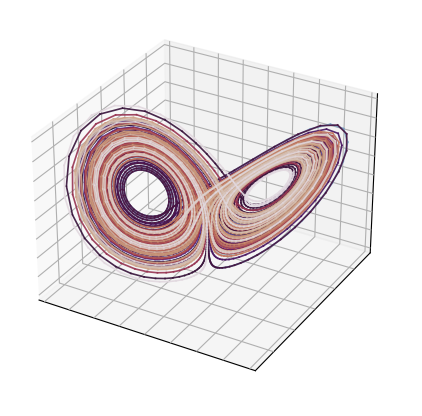

In [48]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

colors = cm.twilight(np.linspace(0, 1, len(lorenz_trajectory)))

for i in range(len(lorenz_trajectory) - 1):
    ax.plot(lorenz_trajectory[i:i+2, 0], lorenz_trajectory[i:i+2, 1], lorenz_trajectory[i:i+2, 2],
            color=colors[i], linewidth=1.2, alpha=0.9)

ax.grid(True)

ax.tick_params(axis='x', colors='none')
ax.tick_params(axis='y', colors='none')
ax.tick_params(axis='z', colors='none')
#plt.savefig("Figures/Lorenz Attractor.png", dpi=600, bbox_inches='tight')
plt.show()

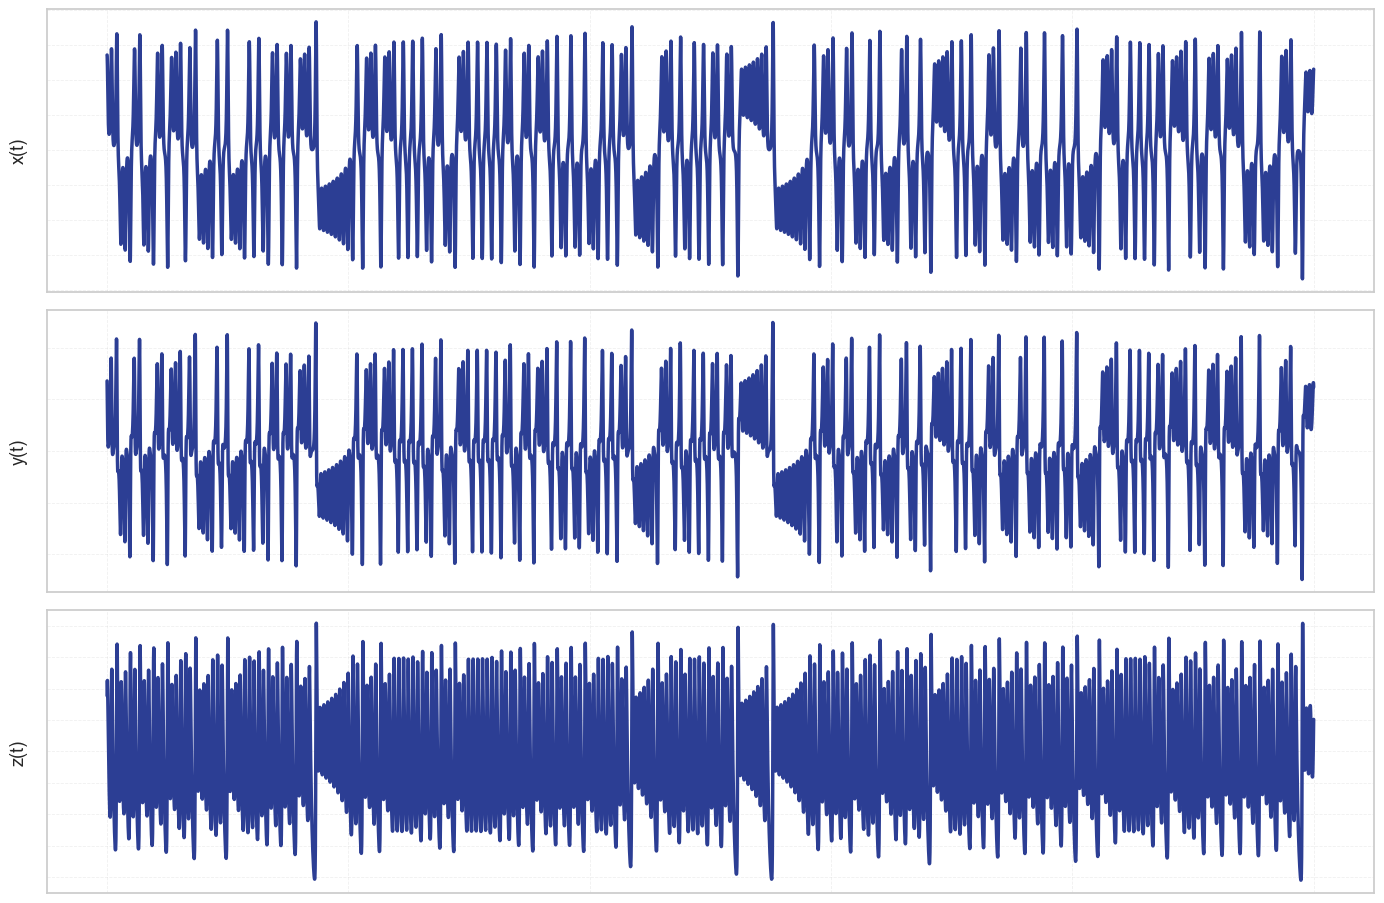

In [ ]:
sns.set(style="whitegrid")

t = np.linspace(0, len(lorenz_trajectory), len(lorenz_trajectory))

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

dims = ['x(t)', 'y(t)', 'z(t)']
line_labels = ['True', 'Poincare']
line_styles = ['--', '-']
line_colors = ['#2c3e94', '#e25822']

for i in range(3):
    axes[i].plot(t, lorenz_trajectory[:, i], label=line_labels[0], linewidth=2.5, color=line_colors[0])
    axes[i].set_ylabel(dims[i], fontsize=13)
    # Hide tick labels (units) on x and y axes
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])

    # Optional: keep tick marks but adjust size if needed
    axes[i].tick_params(axis='both', which='major', labelsize=0)

    axes[i].grid(True, linestyle='--', linewidth=0.6, alpha=0.3)  # alpha adjusted for grid visibility

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Figures/Trajectories for Train Segment.png", dpi=600, bbox_inches='tight')
plt.show()


In [32]:
# Prepare single-step data: input(t) = [x(t), y(t), z(t)], target(t)=[x(t+1), y(t+1), z(t+1)]
inputs = lorenz_trajectory[:-1]
targets = lorenz_trajectory[1:]

In [33]:
data_size = len(lorenz_trajectory)-1
train_size = 9000
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size:]
test_target = targets[train_size:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 9999, train size: 9000, test size: 999


### Rossler System

In [52]:
tmax = 340.0
dt = 0.02
rossler_t_vals, rossler_trajectory = generate_rossler_data(
    initial_state=[1.0, 0.0, 0.0],
    tmax=tmax,
    dt=dt,
    a=0.2,
    b=0.2,
    c=5.7
)

# Discard first 2,000 points as washout
washout = 2000
rossler_t_vals = rossler_t_vals[washout:]
rossler_trajectory = rossler_trajectory[washout:]

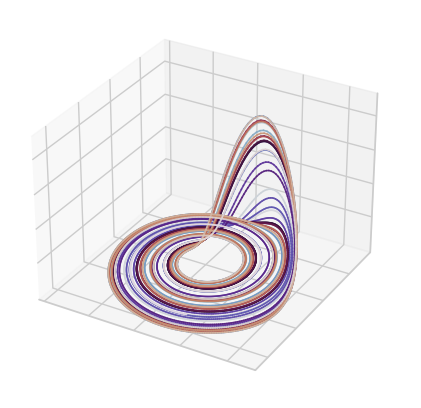

In [53]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

colors = cm.twilight(np.linspace(0, 1, len(rossler_trajectory)))

for i in range(len(rossler_trajectory) - 1):
    ax.plot(rossler_trajectory[i:i+2, 0], rossler_trajectory[i:i+2, 1], rossler_trajectory[i:i+2, 2],
            color=colors[i], linewidth=1.2, alpha=0.9)

ax.grid(True)

ax.tick_params(axis='x', colors='none')
ax.tick_params(axis='y', colors='none')
ax.tick_params(axis='z', colors='none')

plt.savefig("Figures/Rossler Attractor.png", dpi=600, bbox_inches='tight')
plt.show()

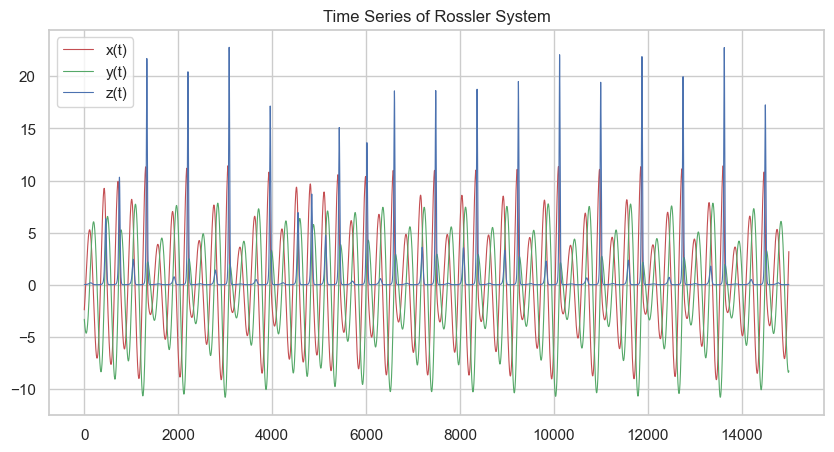

In [54]:
t = np.linspace(0, len(rossler_trajectory), len(rossler_trajectory))

plt.figure(figsize=(10, 5))
plt.plot(t, rossler_trajectory[:, 0], label='x(t)', color='r', lw=0.8)
plt.plot(t, rossler_trajectory[:, 1], label='y(t)', color='g', lw=0.8)
plt.plot(t, rossler_trajectory[:, 2], label='z(t)', color='b', lw=0.8)

plt.title("Time Series of Rossler System")
plt.legend()
plt.show()

In [55]:
# Prepare single-step data: input(t) = [x(t), y(t), z(t)], target(t)=[x(t+1), y(t+1), z(t+1)]
inputs = rossler_trajectory[:-1]
targets = rossler_trajectory[1:]

In [56]:
data_size = len(rossler_trajectory)-1
train_size = 8000
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size:]
test_target = targets[train_size:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 14999, train size: 8000, test size: 6999


### Chen System

In [57]:
tmax = 240.0
dt = 0.02
chen_t_vals, chen_trajectory = generate_chen_data(
    initial_state=[1.0, 1.0, 1.0],
    tmax=tmax,
    dt=dt,
    a=35.0,
    b=3.0,
    c=28.0
)

# Discard first 2,000 points as washout
washout = 2000
chen_t_vals = chen_t_vals[washout:]
chen_trajectory = chen_trajectory[washout:]

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

colors = cm.twilight_r(np.linspace(0, 1, len(chen_trajectory)))

for i in range(len(chen_trajectory) - 1):
    ax.plot(chen_trajectory[i:i+2, 0], chen_trajectory[i:i+2, 1], chen_trajectory[i:i+2, 2],
            color=colors[i], linewidth=1.2, alpha=0.9)

ax.grid(True)

ax.tick_params(axis='x', colors='none')
ax.tick_params(axis='y', colors='none')
ax.tick_params(axis='z', colors='none')

plt.savefig("Figures/Chen Attractor.png", dpi=600, bbox_inches='tight')
plt.show()

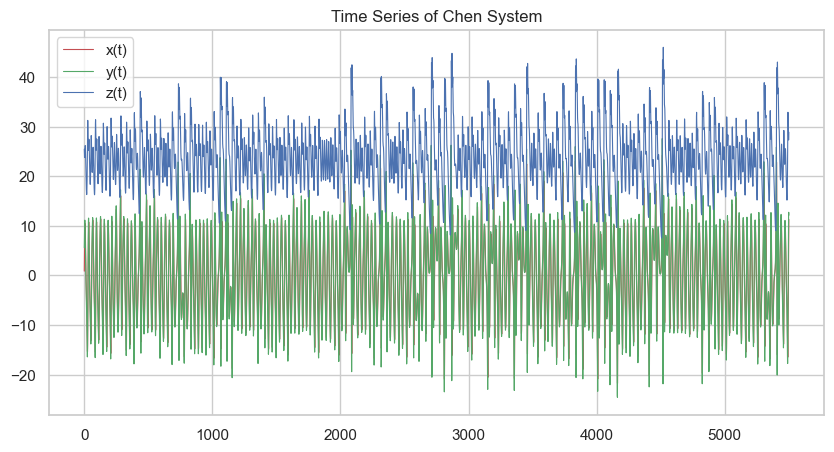

In [ ]:
t = np.linspace(0, len(chen_trajectory), len(chen_trajectory))

plt.figure(figsize=(10, 5))
plt.plot(t, chen_trajectory[:, 0], label='x(t)', color='r', lw=0.8)
plt.plot(t, chen_trajectory[:, 1], label='y(t)', color='g', lw=0.8)
plt.plot(t, chen_trajectory[:, 2], label='z(t)', color='b', lw=0.8)

plt.title("Time Series of Chen System")
plt.legend()
plt.show()

In [ ]:
# Prepare single-step data: input(t) = [x(t), y(t), z(t)], target(t)=[x(t+1), y(t+1), z(t+1)]
inputs = chen_trajectory[:-1]
targets = chen_trajectory[1:]

In [ ]:
data_size = len(chen_trajectory)-1
train_size = 9000
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size:]
test_target = targets[train_size:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 9999, train size: 9000, test size: 999


### Chua System

In [93]:
tmax = 250.0
dt = 0.02
chua_t_vals, chua_trajectory = generate_chua_data(
    initial_state=[0.2, 0.0, 0.0], 
    tmax=tmax,
    dt=dt,
    alpha=15.6,
    beta=28.0,
    m0=-1.143,
    m1=-0.714
)

# Discard first 2,000 points as washout
washout = 2000
chua_t_vals = chua_t_vals[washout:]
chua_trajectory = chua_trajectory[washout:]

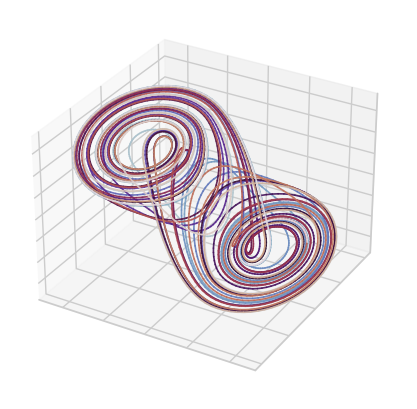

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

colors = cm.twilight(np.linspace(0, 1, len(chua_trajectory)))

for i in range(len(chen_trajectory) - 1):
    ax.plot(chua_trajectory[i:i+2, 0], chua_trajectory[i:i+2, 1], chua_trajectory[i:i+2, 2],
            color=colors[i], linewidth=1.2, alpha=0.9)

ax.grid(True)

ax.tick_params(axis='x', colors='none')
ax.tick_params(axis='y', colors='none')
ax.tick_params(axis='z', colors='none')

plt.savefig("Figures/Chua Attractor.png", dpi=600, bbox_inches='tight')
plt.show()

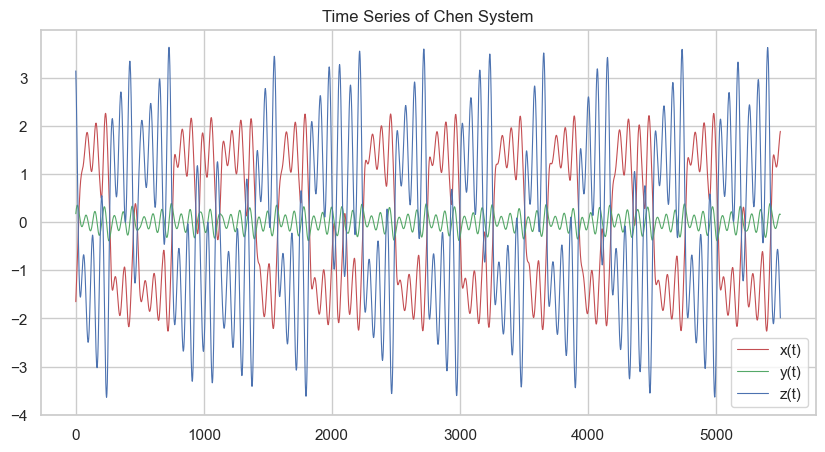

In [ ]:
t = np.linspace(0, len(chua_trajectory), len(chua_trajectory))

plt.figure(figsize=(10, 5))
plt.plot(t, chua_trajectory[:, 0], label='x(t)', color='r', lw=0.8)
plt.plot(t, chua_trajectory[:, 1], label='y(t)', color='g', lw=0.8)
plt.plot(t, chua_trajectory[:, 2], label='z(t)', color='b', lw=0.8)

plt.title("Time Series of Chen System")
plt.legend()
plt.show()

In [94]:
# Prepare single-step data: input(t) = [x(t), y(t), z(t)], target(t)=[x(t+1), y(t+1), z(t+1)]
inputs = chua_trajectory[:-1]
targets = chua_trajectory[1:]

In [95]:
data_size = len(chua_trajectory)-1
train_size = 9000
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size:]
test_target = targets[train_size:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 10499, train size: 9000, test size: 1499


# Teacher-forced Single-step Forecasting

### Models Initialization

In [52]:
# Baseline ESN
esn = BaselineESN3D(
    reservoir_size=300,
    spectral_radius=1.0,
    connectivity=0.05,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
esn.fit_readout(train_input, train_target, discard=100)
esn_preds = esn.predict(test_input)

In [53]:
# Cycle Reservoir
cycle_res = CycleReservoir3D(
    reservoir_size=300,
    spectral_radius=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
cycle_res.fit_readout(train_input, train_target, discard=100)
cycle_res_preds = cycle_res.predict(test_input)

In [54]:
crj = CRJRes3D(
    reservoir_size=300,
    jump=15,
    spectral_radius=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
crj.fit_readout(train_input, train_target, discard=100)
crj_preds = crj.predict(test_input)

In [55]:
sw_esn = SWRes3D(
    reservoir_size=300,
    rewiring_prob=0.1,
    degree=3,
    spectral_radius=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
sw_esn.fit_readout(train_input, train_target, discard=100)
sw_esn_preds = sw_esn.predict(test_input)

In [58]:
mci_esn = MCIESN3D(
    reservoir_size=150,
    cycle_weight=0.8,
    connect_weight=0.8,
    combine_factor=0.5,
    spectral_radius=1.0,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
mci_esn.fit_readout(train_input, train_target, discard=100)
mci_esn_preds = mci_esn.predict(test_input)

In [59]:
deepesn = DeepESN3D(
    num_layers=3,
    reservoir_size=100,
    spectral_radius=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-6,
    seed=1002
)
deepesn.fit_readout(train_input, train_target, discard=100)
deepesn_preds = deepesn.predict(test_input)

In [115]:
psec = PoincareSectionRes3D(
        normal_vec=np.array([1, 0, 1]),
        delta=25,
        M=200,
        spectral_radius=0.95,
        input_scale=0.1,
        leaking_rate=0.2,
        ridge_alpha=1e-6,
        seed=123
    )
psec.fit_readout(train_input, train_target, discard=100)
psec_preds = psec.predict(test_input)

### NRMSE Report

In [116]:
# Define horizons to test
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]

In [ ]:
esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
psec_nrmse = evaluate_nrmse(psec_preds, test_target, all_horizons)

In [ ]:
# Print results
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<15} {'SCR':<15} {'CRJ':<15} {'SW-ESN':<15} {'MCI-ESN':<15} {'DeepESN':<15} {'Poincare':<15}")
print("-" * 140)

for horizon in horizons:
    print(f"{horizon:<10} {np.mean(esn_nrmse[horizon]):<15.7f} {np.mean(cycle_res_nrmse[horizon]):<15.7f} {np.mean(crj_nrmse[horizon]):<15.7f} {np.mean(sw_esn_nrmse[horizon]):<15.7f} {np.mean(mci_esn_nrmse[horizon]):<15.7f} {np.mean(deepesn_nrmse[horizon]):<15.7f} {np.mean(psec_nrmse[horizon]):<15.7f}")

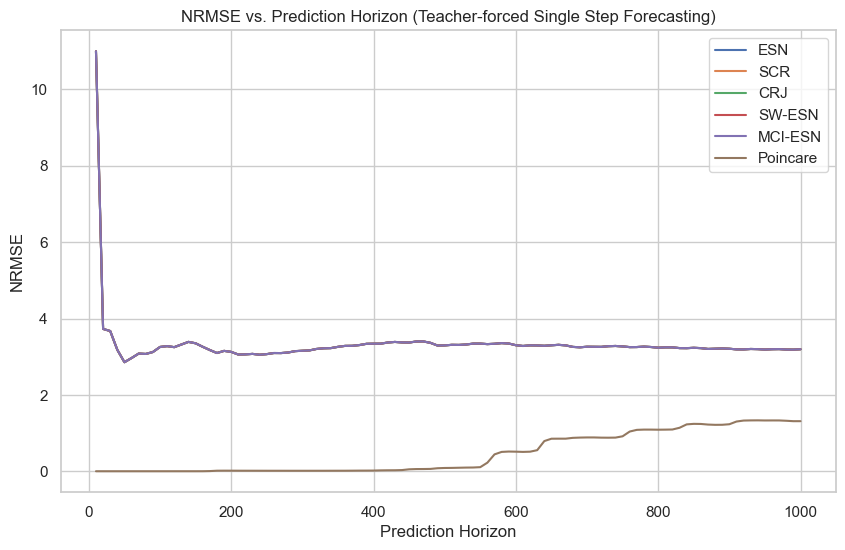

In [ ]:
# Plot NRMSE vs Horizon
plot_len=1000
steps = list(range(10, plot_len+1, 10))

plt.figure(figsize=(10, 6))
plt.plot(steps, [np.mean(esn_nrmse[s]) for s in steps], label='ESN')
plt.plot(steps, [np.mean(cycle_res_nrmse[s]) for s in steps], label='SCR')
plt.plot(steps, [np.mean(crj_nrmse[s]) for s in steps], label='CRJ')
plt.plot(steps, [np.mean(sw_esn_nrmse[s]) for s in steps], label='SW-ESN')
plt.plot(steps, [np.mean(mci_esn_nrmse[s]) for s in steps], label='MCI-ESN')
#plt.plot(steps, [np.mean(deepesn_nrmse[s]) for s in steps], label='DeepESN')
plt.plot(steps, [np.mean(psec_nrmse[s]) for s in steps], label='Poincare')
plt.xlabel('Prediction Horizon')
plt.ylabel('NRMSE')
plt.title('NRMSE vs. Prediction Horizon (Teacher-forced Single Step Forecasting)')
plt.legend()
plt.savefig("Figures/NRMSE vs. Prediction Horizon (Teacher-forced Single Step Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

### Trajectory Plots

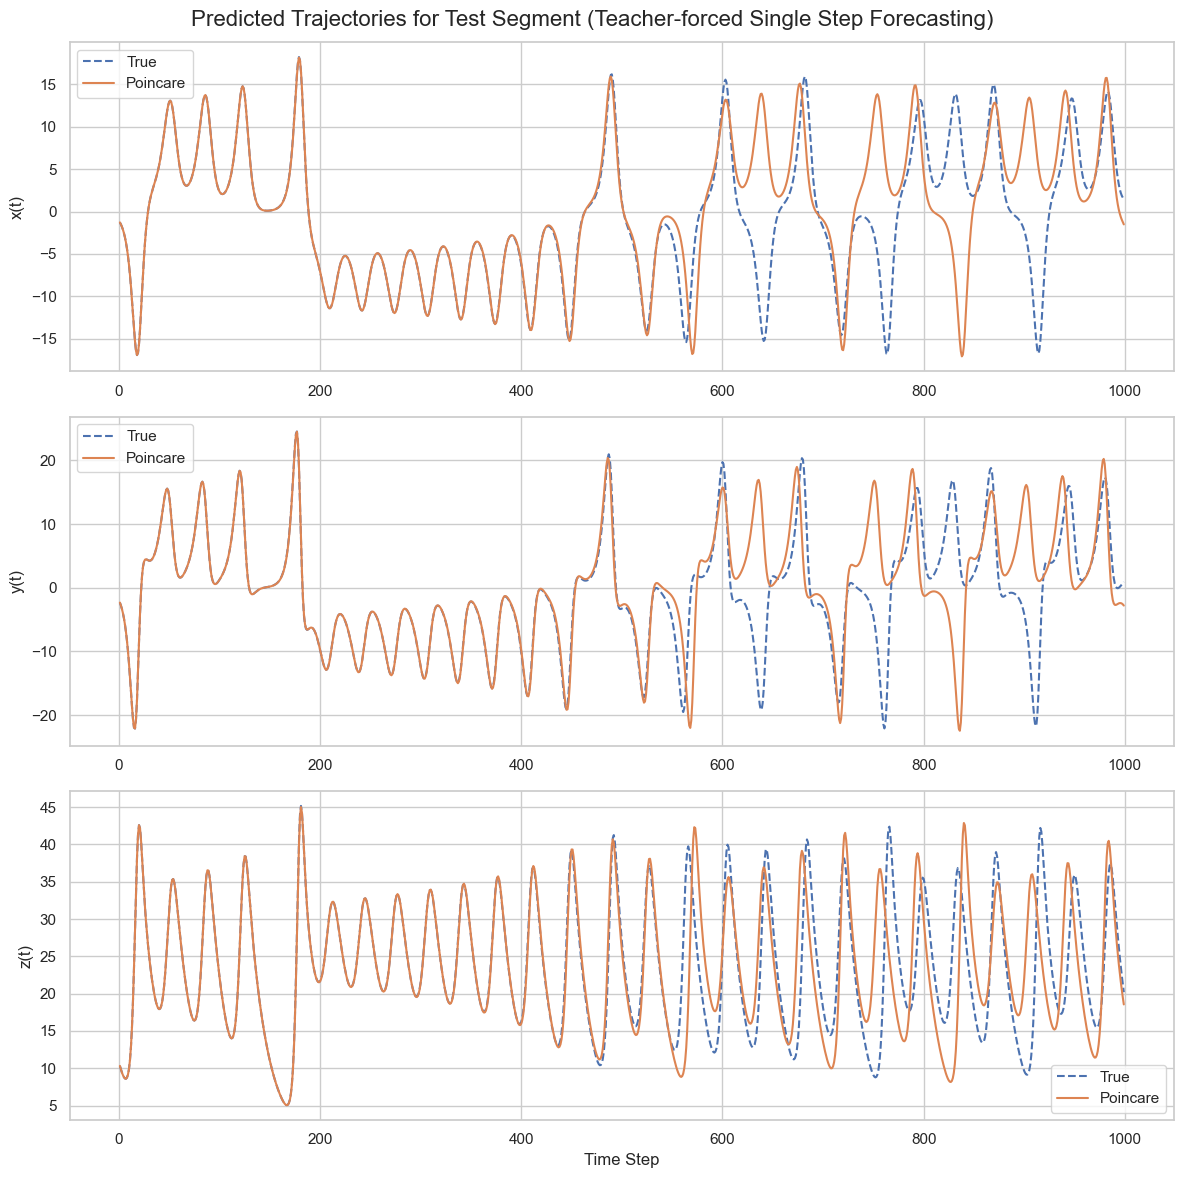

In [128]:
plot_len = 999
steps = list(range(1, plot_len+1))

# Create subplots for x, y, z dimensions
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

dims = ['x(t)', 'y(t)', 'z(t)']
for i in range(3):
    axes[i].plot(steps, test_target[:plot_len, i], label='True', linestyle='dashed')
    # axes[i].plot(steps, esn_preds[:plot_len, i], label='ESN')
    # axes[i].plot(steps, cycle_res_preds[:plot_len, i], label='CycleRes')
    axes[i].plot(steps, psec_preds[:plot_len, i], label='Poincare')
    axes[i].set_ylabel(dims[i])
    axes[i].legend()

axes[-1].set_xlabel('Time Step')
fig.suptitle('Predicted Trajectories for Test Segment (Teacher-forced Single Step Forecasting)', fontsize=16)
plt.tight_layout()
plt.savefig("Figures/Predicted Trajectories for Test Segment (Teacher-forced Single Step Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

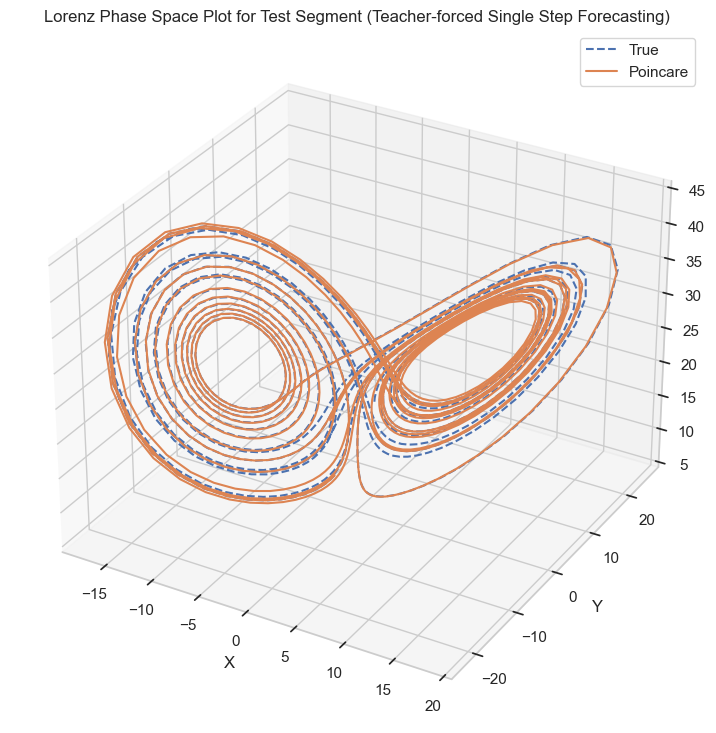

In [129]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.plot(test_target[:plot_len,0], test_target[:plot_len,1], test_target[:plot_len,2], label='True', linestyle='dashed')
ax.plot(psec_preds[:plot_len,0], psec_preds[:plot_len,1], psec_preds[:plot_len,2], label='Poincare')
ax.set_title('Lorenz Phase Space Plot for Test Segment (Teacher-forced Single Step Forecasting)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()
plt.savefig("Figures/Lorenz Phase Space Plot for Test Segment (Teacher-forced Single Step Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

# Autoregressive Forecasting

In [130]:
initial_input = test_input[0]
num_steps = len(test_input)

### Models Initialization

In [131]:
# Baseline ESN
esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.99,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=1002
    )
esn.fit_readout(train_input, train_target, discard=100)
esn_preds = esn.autoregressive_predict(initial_input, num_steps)

In [132]:
# Cycle Reservoir
cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-4,
        seed=1002
    )
cycle_res.fit_readout(train_input, train_target, discard=100)
cycle_res_preds = cycle_res.autoregressive_predict(initial_input, num_steps)

In [133]:
crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=10,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-4,
    seed=1002
)
crj.fit_readout(train_input, train_target, discard=100)
crj_preds = crj.autoregressive_predict(initial_input, num_steps)

In [134]:
sw_esn = SWRes3D(
    reservoir_size=300,
    rewiring_prob=0.3,
    degree=2,
    spectral_radius=0.99,
    input_scale=0.2,
    leaking_rate=0.7,
    ridge_alpha=1e-5,
    seed=1002
)
sw_esn.fit_readout(train_input, train_target, discard=100)
sw_esn_preds = sw_esn.autoregressive_predict(initial_input, num_steps)

In [135]:
mci_esn = MCIESN3D(
    reservoir_size=300,
    cycle_weight=0.8,
    connect_weight=0.8,
    combine_factor=0.1,
    v1=0.03,
    v2=0.03,
    spectral_radius=0.8,
    leaking_rate=0.8,
    ridge_alpha=1e-5,
    seed=1002
)
mci_esn.fit_readout(train_input, train_target, discard=100)
mci_esn_preds = mci_esn.autoregressive_predict(initial_input, num_steps)

In [136]:
deepesn = DeepESN3D(
    num_layers=3,
    reservoir_size=100,
    spectral_radius=0.99,
    connectivity=1.0,
    input_scale=0.2,
    leaking_rate=0.8,
    ridge_alpha=1e-4,
    seed=1002
)
deepesn.fit_readout(train_input, train_target, discard=100)
deepesn_preds = deepesn.autoregressive_predict(initial_input, num_steps)

In [138]:
psec = PoincareSectionRes3D(
        normal_vec=np.array([1, 0, 1]),
        delta=25,
        M=200,
        spectral_radius=0.95,
        input_scale=0.1,
        leaking_rate=0.2,
        ridge_alpha=1e-6,
        seed=123
    )
psec.fit_readout(train_input, train_target, discard=100)
psec_preds = psec.predict(initial_input, num_steps)

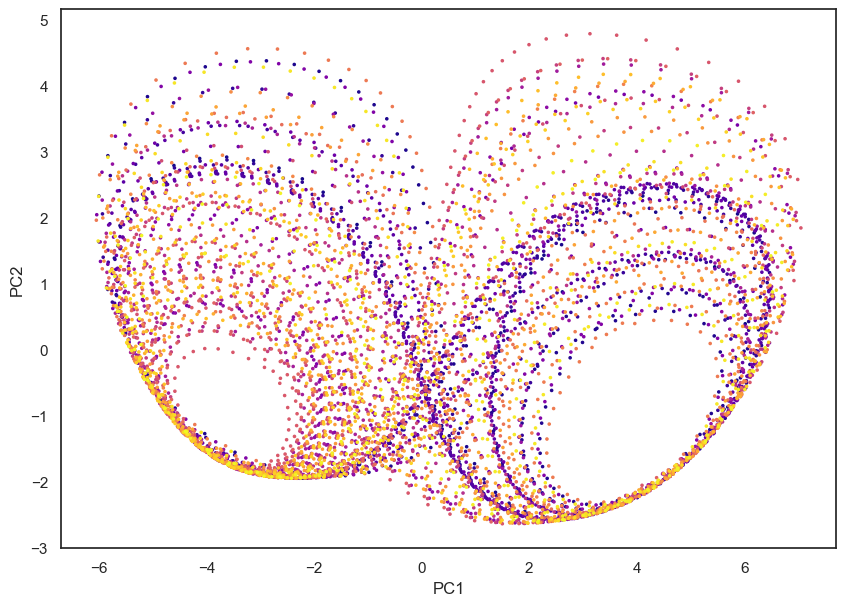

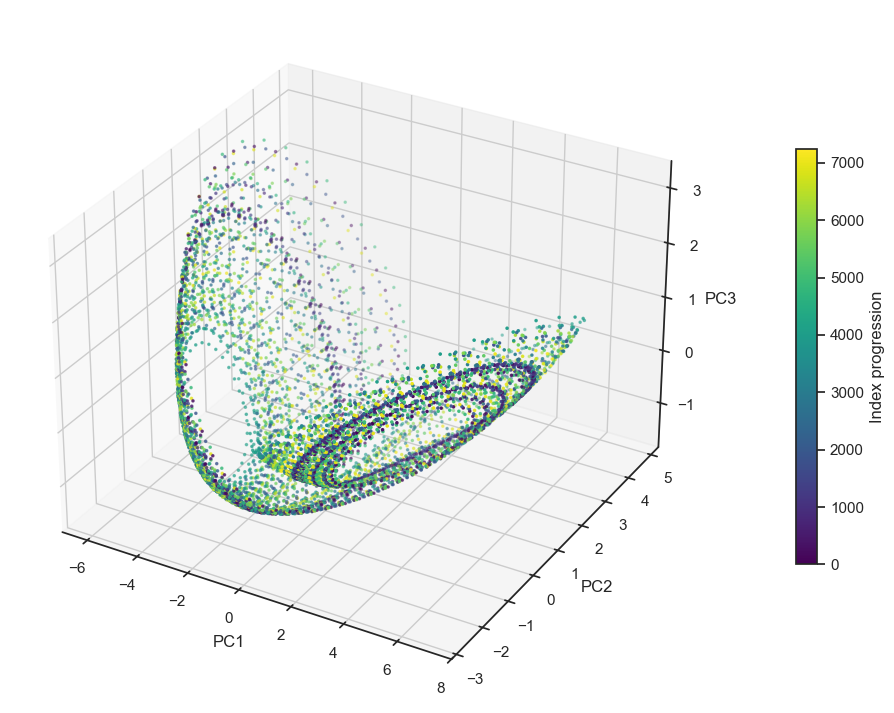

In [140]:
states, _ = psec.collect_states(train_input, discard=100)  # shape (T-1000, reservoir_dim)
plot_pca_projection2d(states)
plot_pca_projection3d(states)

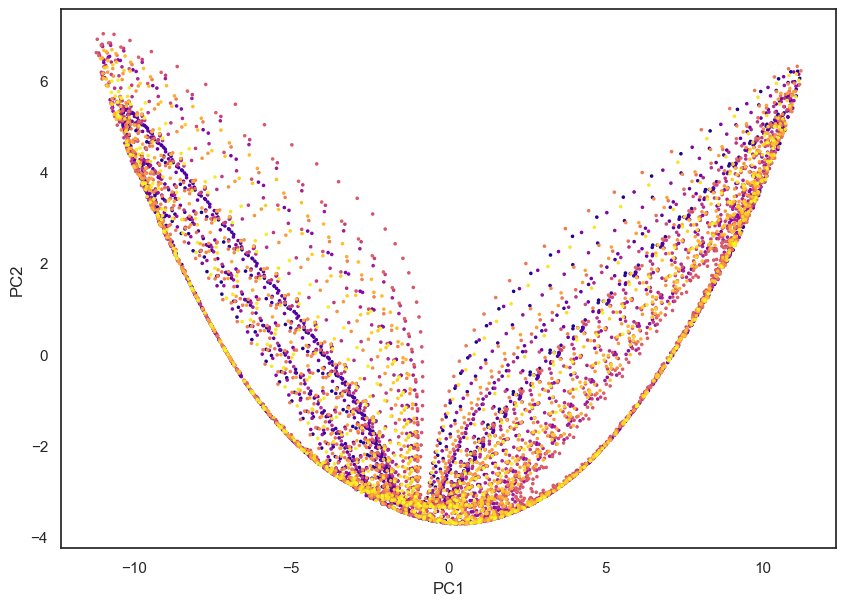

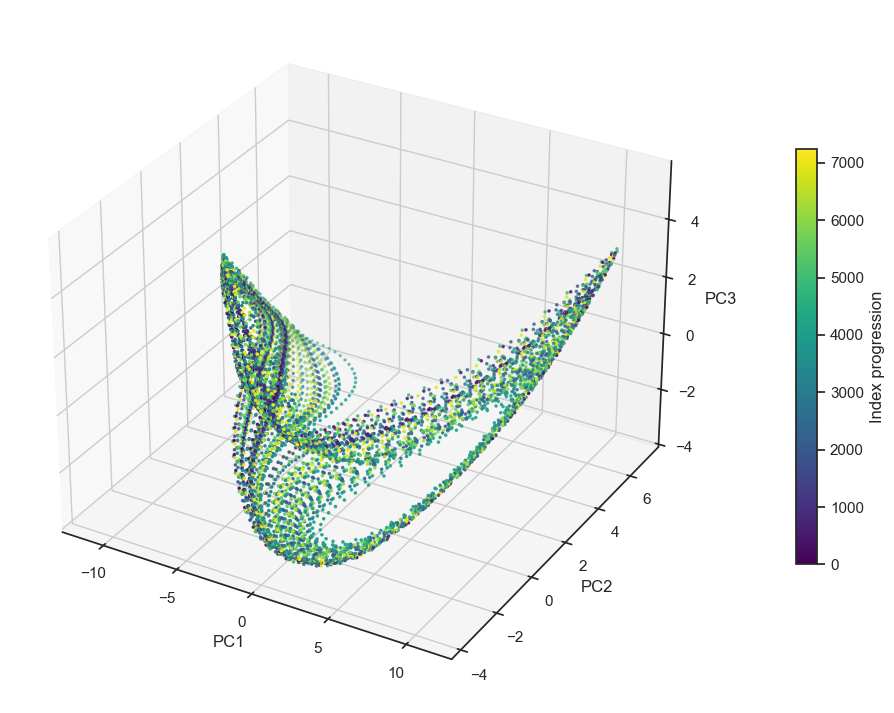

In [141]:
states, _ = esn.collect_states(train_input, discard=100)  # shape (T-1000, reservoir_dim)
plot_pca_projection2d(states)
plot_pca_projection3d(states)

### NRMSE Report

In [ ]:
esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
psec_nrmse = evaluate_nrmse(psec_preds, test_target, all_horizons)

# Print results
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 120)
print(f"{'Horizon':<10} {'ESN':<15} {'SCR':<15} {'CRJ':<15} {'SW-ESN':<15} {'MCI-ESN':<15} {'DeepESN':<15} {'Poincare':<15}")
print("-" * 120)

for horizon in horizons:
    print(f"{horizon:<10} {np.mean(esn_nrmse[horizon]):<15.7f} {np.mean(cycle_res_nrmse[horizon]):<15.7f} {np.mean(crj_nrmse[horizon]):<15.7f} {np.mean(sw_esn_nrmse[horizon]):<15.7f} {np.mean(mci_esn_nrmse[horizon]):<15.7f} {np.mean(deepesn_nrmse[horizon]):<15.7f} {np.mean(psec_nrmse[horizon]):<15.7f}")

### VPT Report

In [ ]:
lle_lorenz = 0.830
lyapunov_time_lorenz = 1.0 / lle_lorenz
VPT_threshold = 0.3
test_time = np.arange(test_size)*dt

esn_VPT, esn_VPT_ratio = compute_valid_prediction_time(test_target, esn_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
cycle_res_VPT, cycle_res_VPT_ratio = compute_valid_prediction_time(test_target, cycle_res_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
crj_VPT, crj_VPT_ratio = compute_valid_prediction_time(test_target, crj_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
sw_esn_VPT, sw_esn_VPT_ratio = compute_valid_prediction_time(test_target, sw_esn_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
mci_esn_VPT, mci_esn_VPT_ratio = compute_valid_prediction_time(test_target, mci_esn_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
deepesn_VPT, deepesn_VPT_ratio = compute_valid_prediction_time(test_target, deepesn_preds, test_time, lyapunov_time_lorenz, VPT_threshold)
psec_VPT, psec_VPT_ratio = compute_valid_prediction_time(test_target, psec_preds, test_time, lyapunov_time_lorenz, VPT_threshold)

In [ ]:
print(f"{'':<20} {'ESN':<15} {'SCR':<15} {'CRJ':<15} {'SW-ESN':<15} {'MCI-ESN':<15} {'DeepESN':<15} {'Poincare':<15}")
print("-" * 140)
print(f"{'T_VPT':<20} {esn_VPT:<15.3f} {cycle_res_VPT:<15.3f} {crj_VPT:<15.3f} {sw_esn_VPT:<15.3f} {mci_esn_VPT:<15.3f} {deepesn_VPT:<15.3f} {psec_VPT:<15.3f}")
print(f"{'T_VPT/T_lambda':<20} {esn_VPT_ratio:<15.3f} {cycle_res_VPT_ratio:<15.3f} {crj_VPT_ratio:<15.3f} {sw_esn_VPT_ratio:<15.3f} {mci_esn_VPT_ratio:<15.3f} {deepesn_VPT_ratio:<15.3f} {psec_VPT_ratio:<15.3f}")

### Adev Report

In [ ]:
cube_size = (4, 4, 4)
esn_adev = compute_attractor_deviation(esn_preds, test_target, cube_size)
cycle_res_adev = compute_attractor_deviation(cycle_res_preds, test_target, cube_size)
crj_adev = compute_attractor_deviation(crj_preds, test_target, cube_size)
sw_esn_adev = compute_attractor_deviation(sw_esn_preds, test_target, cube_size)
mci_esn_adev = compute_attractor_deviation(mci_esn_preds, test_target, cube_size)
deepesn_adev = compute_attractor_deviation(deepesn_preds, test_target, cube_size)
psec_adev = compute_attractor_deviation(psec_preds, test_target, cube_size)

print(f"{'':<20} {'ESN':<15} {'SCR':<15} {'CRJ':<15} {'SW-ESN':<15} {'MCI-ESN':<15} {'DeepESN':<15} {'Poincare':<15}")
print("-" * 140)
print(f"{'ADev':<20} {esn_adev:<15} {cycle_res_adev:<15} {crj_adev:<15} {sw_esn_adev:<15} {mci_esn_adev:<15} {deepesn_adev:<15} {psec_adev:<15}")

### PSD Report

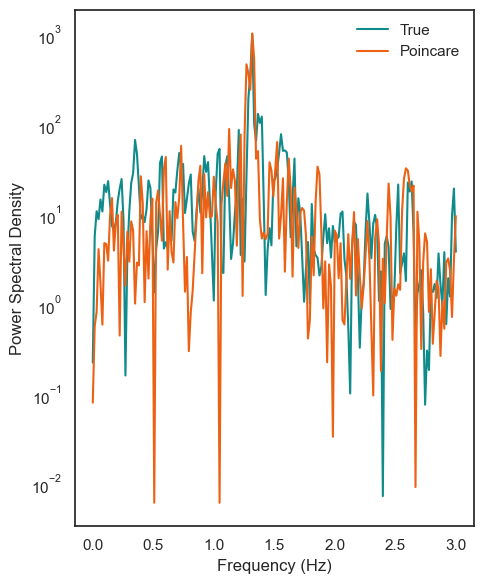

In [ ]:
target_freqs, target_psd = compute_psd(test_target, dt=dt)
esn_freqs, esn_psd = compute_psd(esn_preds, dt=dt)
# cycle_res_freqs, cycle_res_psd = compute_psd(cycle_res_preds, dt=dt)
# crj_freqs, crj_psd = compute_psd(crj_preds, dt=dt)
# sw_esn_freqs, sw_esn_psd = compute_psd(sw_esn_preds, dt=dt)
# mci_esn_freqs, mci_esn_psd = compute_psd(mci_esn_preds, dt=dt)
# deepesn_freqs, deepesn_psd = compute_psd(deepesn_preds, dt=dt)
psec_freqs, psec_psd = compute_psd(psec_preds, dt=dt)


# Plot the PSDs
mask = target_freqs <= 3
plt.figure(figsize=(5, 6))

# True signal
plt.semilogy(target_freqs[mask], target_psd[mask], label='True', linewidth=1.5, color='#108B8B')

plt.semilogy(psec_freqs[mask], psec_psd[mask], label='Poincare', linewidth=1.5, color='#EC6113')

# Labels and formatting
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Power Spectral Density', fontsize=12)
# plt.legend(fontsize=11, frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.0)
plt.legend(fontsize=11, frameon=False, loc='best')

plt.tight_layout()
plt.savefig("Figures/PSD_vs_Frequency_rossler_esn.png", dpi=600, bbox_inches='tight')
plt.show()



### Trajectory Plots

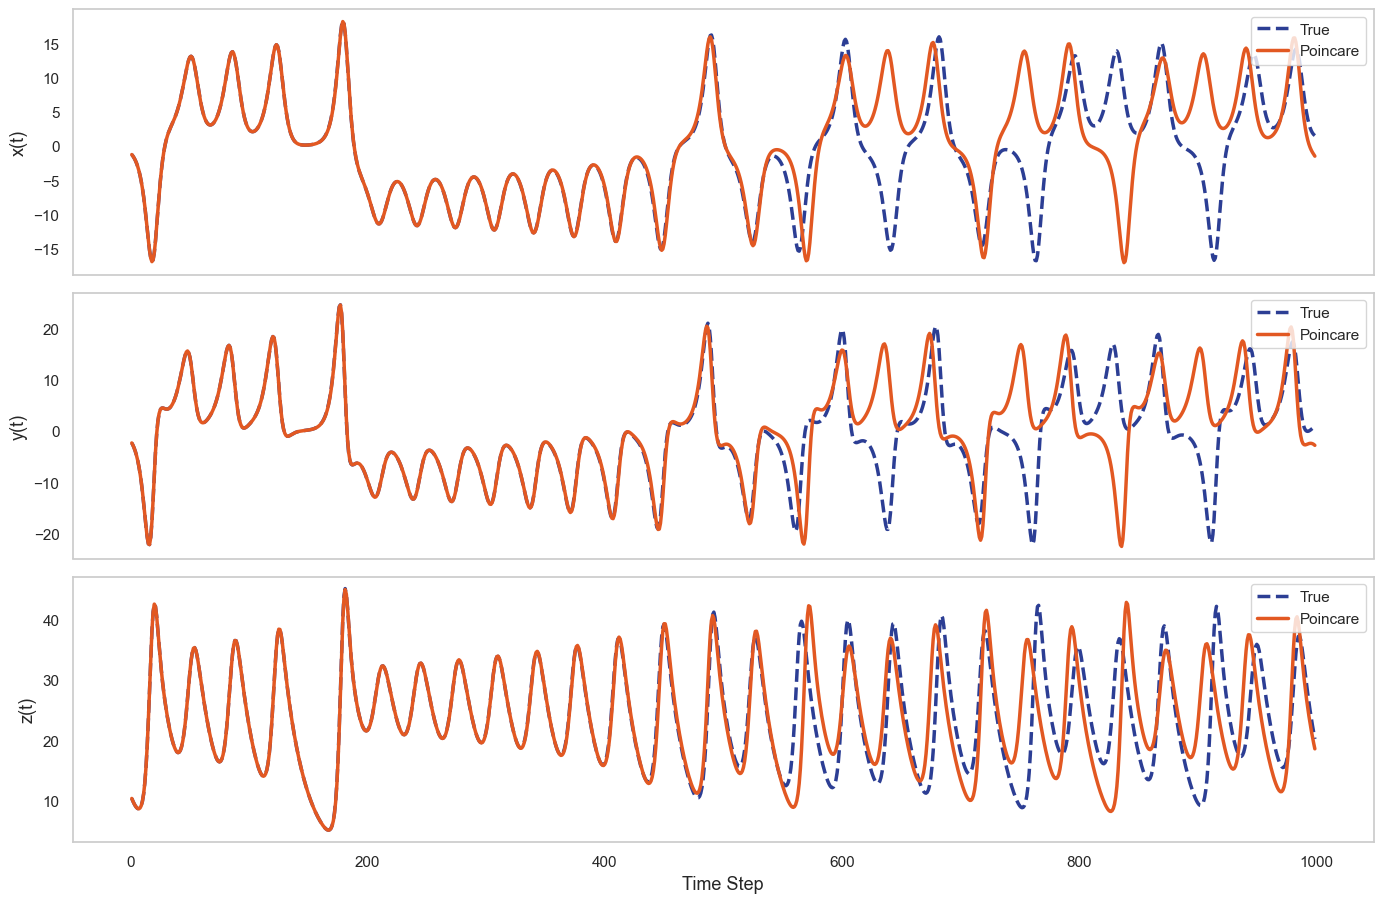

In [149]:
sns.set(style="whitegrid")

plot_len = 999
steps = list(range(1, plot_len + 1))

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

dims = ['x(t)', 'y(t)', 'z(t)']
line_labels = ['True', 'Poincare']
line_styles = ['--', '-']
line_colors = ['#2c3e94', '#e25822']

for i in range(3):
    axes[i].plot(steps, test_target[:plot_len, i], label=line_labels[0],
                 linestyle=line_styles[0], linewidth=2.5, color=line_colors[0])
    axes[i].plot(steps, psec_preds[:plot_len, i], label=line_labels[1],
                 linestyle=line_styles[1], linewidth=2.5, color=line_colors[1])
    
    axes[i].set_ylabel(dims[i], fontsize=13)
    axes[i].legend(loc='upper right', fontsize=11, frameon=True)
    axes[i].tick_params(axis='both', which='major', labelsize=11)
    axes[i].grid(True, linestyle='--', linewidth=0.6, alpha=0.0)

axes[-1].set_xlabel('Time Step', fontsize=13)
# fig.suptitle('Predicted Trajectories for Test Segment (Autoregressive Forecasting)', 
#              fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Figures/Predicted Trajectories for Lorenz Test Segment - Poincare.png", dpi=600, bbox_inches='tight')
plt.show()


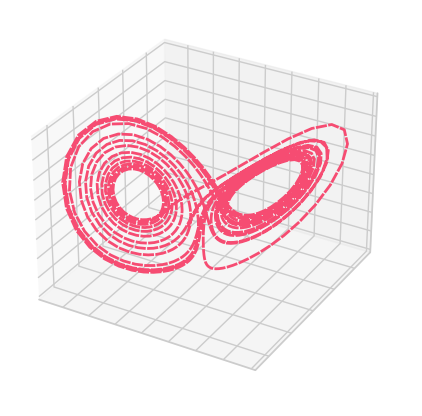

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

# Plot True vs Predicted
line, = ax.plot(psec_preds[:plot_len, 0],
                psec_preds[:plot_len, 1],
                psec_preds[:plot_len, 2],
                label='True Trajectory',
                linewidth=2,
                color='#F64C72')
line.set_dashes([4, 0.5])

ax.grid(True)

ax.tick_params(axis='x', colors='none')
ax.tick_params(axis='y', colors='none')
ax.tick_params(axis='z', colors='none')
# Save the figure
plt.savefig("Figures/Test Segment Lorenz - Poincare.png", dpi=600, bbox_inches='tight')
plt.show()


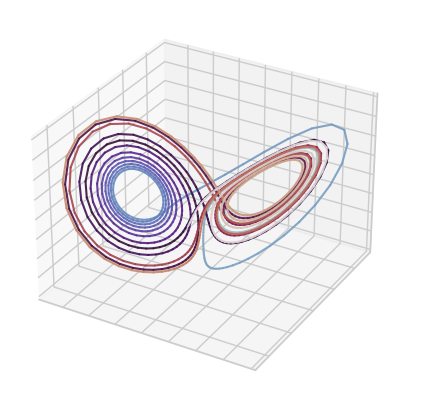

In [151]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

# Define the color map based on the number of segments
colors = cm.twilight(np.linspace(0, 1, len(test_target[:plot_len])))

# Plot each segment of the trajectory with its corresponding color
for i in range(plot_len - 1):
    ax.plot(psec_preds[i:i+2, 0],
            psec_preds[i:i+2, 1],
            psec_preds[i:i+2, 2],
            color=colors[i], linewidth=1.5, alpha=0.9)

# Add grid and hide tick marks
ax.grid(True)
ax.tick_params(axis='x', colors='none')
ax.tick_params(axis='y', colors='none')
ax.tick_params(axis='z', colors='none')

plt.savefig("Figures/Lorenz Phase Space — Test Segment (Autoregressive Forecasting).png", dpi=600, bbox_inches='tight')
plt.show()

# Experiments

## Experiments on Lorenz Dataset under Autoregressive Forecasting

In [34]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_lorenz = 0.905
lyapunov_time_lorenz = 1.0 / lle_lorenz
lyapunov_time = lyapunov_time_lorenz
VPT_threshold = 0.4
test_time = np.arange(test_size)*dt
cube_size = (4, 4, 4)
seeds = range(1, 31)


nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

In [61]:
nrmse_dict['ESN'] = []
VPT_dict['ESN'] = []
VPT_ratio_dict['ESN'] = []
adev_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.99,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.autoregressive_predict(initial_input, num_steps)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)
    esn_VPT, esn_VPT_ratio = compute_valid_prediction_time(test_target, esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['ESN'].append(esn_VPT)
    VPT_ratio_dict['ESN'].append(esn_VPT_ratio)
    esn_adev = compute_attractor_deviation(esn_preds, test_target, cube_size)
    adev_dict['ESN'].append(esn_adev)

In [36]:
nrmse_dict['SCR'] = []
VPT_dict['SCR'] = []
VPT_ratio_dict['SCR'] = []
adev_dict['SCR'] = []

for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-4,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.autoregressive_predict(initial_input, num_steps)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)
    cycle_res_VPT, cycle_res_VPT_ratio = compute_valid_prediction_time(test_target, cycle_res_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SCR'].append(cycle_res_VPT)
    VPT_ratio_dict['SCR'].append(cycle_res_VPT_ratio)
    cycle_res_adev = compute_attractor_deviation(cycle_res_preds, test_target, cube_size)
    adev_dict['SCR'].append(cycle_res_adev)

In [37]:
nrmse_dict['CRJ'] = []
VPT_dict['CRJ'] = []
VPT_ratio_dict['CRJ'] = []
adev_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=10,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-4,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.autoregressive_predict(initial_input, num_steps)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)
    crj_VPT, crj_VPT_ratio = compute_valid_prediction_time(test_target, crj_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['CRJ'].append(crj_VPT)
    VPT_ratio_dict['CRJ'].append(crj_VPT_ratio)
    crj_adev = compute_attractor_deviation(crj_preds, test_target, cube_size)
    adev_dict['CRJ'].append(crj_adev)

In [38]:
nrmse_dict['SW-ESN'] = []
VPT_dict['SW-ESN'] = []
VPT_ratio_dict['SW-ESN'] = []
adev_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.3,
        degree=2,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-5,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.autoregressive_predict(initial_input, num_steps)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)
    sw_esn_VPT, sw_esn_VPT_ratio = compute_valid_prediction_time(test_target, sw_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SW-ESN'].append(sw_esn_VPT)
    VPT_ratio_dict['SW-ESN'].append(sw_esn_VPT_ratio)
    sw_esn_adev = compute_attractor_deviation(sw_esn_preds, test_target, cube_size)
    adev_dict['SW-ESN'].append(sw_esn_adev)

In [39]:
nrmse_dict['MCI-ESN'] = []
VPT_dict['MCI-ESN'] = []
VPT_ratio_dict['MCI-ESN'] = []
adev_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.03,
        v2=0.03,
        spectral_radius=0.8,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.autoregressive_predict(initial_input, num_steps)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)
    mci_esn_VPT, mci_esn_VPT_ratio = compute_valid_prediction_time(test_target, mci_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['MCI-ESN'].append(mci_esn_VPT)
    VPT_ratio_dict['MCI-ESN'].append(mci_esn_VPT_ratio)
    mci_esn_adev = compute_attractor_deviation(mci_esn_preds, test_target, cube_size)
    adev_dict['MCI-ESN'].append(mci_esn_adev)

In [40]:
nrmse_dict['DeepESN'] = []
VPT_dict['DeepESN'] = []
VPT_ratio_dict['DeepESN'] = []
adev_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        connectivity=1.0,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.autoregressive_predict(initial_input, num_steps)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)
    deepesn_VPT, deepesn_VPT_ratio = compute_valid_prediction_time(test_target, deepesn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['DeepESN'].append(deepesn_VPT)
    VPT_ratio_dict['DeepESN'].append(deepesn_VPT_ratio)
    deepesn_adev = compute_attractor_deviation(deepesn_preds, test_target, cube_size)
    adev_dict['DeepESN'].append(deepesn_adev)

In [35]:
nrmse_dict['Poincare'] = []
VPT_dict['Poincare'] = []
VPT_ratio_dict['Poincare'] = []
adev_dict['Poincare'] = []

# for seed in seeds:
for seed in [1]:
    psec = PoincareSectionRes3D(
            normal_vec=np.array([1, 0, 3]),
            delta=25, # 25
            M=250, # strategically taken as half the size of baselines
            spectral_radius=0.1, # 0.95
            input_scale=0.1,
            leaking_rate=0.2,
            ridge_alpha=1e-13,
            seed=seed
        )

    psec.fit_readout(train_input, train_target, discard=100)
    psec_preds = psec.autoregressive_predict(initial_input, num_steps)
    psec_nrmse = evaluate_nrmse(psec_preds, test_target, all_horizons)
    nrmse_dict['Poincare'].append(psec_nrmse)
    psec_VPT, psec_VPT_ratio = compute_valid_prediction_time(test_target, psec_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['Poincare'].append(psec_VPT)
    VPT_ratio_dict['Poincare'].append(psec_VPT_ratio)
    psec_adev = compute_attractor_deviation(psec_preds, test_target, cube_size)
    adev_dict['Poincare'].append(psec_adev)


c:\Users\ashut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


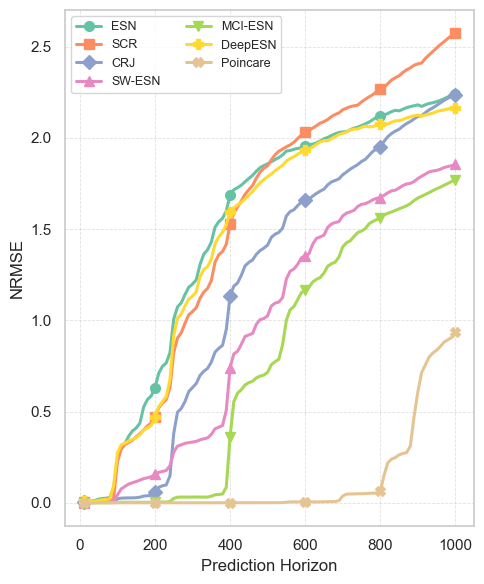

In [80]:
plot_len = 1000
steps = list(range(10, plot_len + 1, 10))
marker_steps = [10, 200, 400, 600, 800, 1000]

models = {
    'ESN': esn_nrmse,
    'SCR': cycle_res_nrmse,
    'CRJ': crj_nrmse,
    'SW-ESN': sw_esn_nrmse,
    'MCI-ESN': mci_esn_nrmse,
    'DeepESN': deepesn_nrmse,
    'Poincare': psec_nrmse
}

# Assign a unique marker and color style for each
# Use a different colormap for more variety
colors = plt.cm.Set2.colors  # Set2 has 8 distinct pastel colors
markers = ['o', 's', 'D', '^', 'v', 'P', 'X']

plt.figure(figsize=(5, 6))

for i, (name, data) in enumerate(models.items()):
    values = [np.mean(data[s]) for s in steps]
    color = colors[i % len(colors)]
    marker = markers[i % len(markers)]
    values = []

    for horizon in all_horizons:
        # Get all NRMSE values across all runs for this model and this horizon
        all_vals = []
        for run in nrmse_dict[name]:
            all_vals.extend([np.mean(run[horizon])])
        values.append(np.mean(all_vals))

    # Plot with markers so legend also shows them
    plt.plot(steps, values, label=name, linewidth=2.2, color=color,
             marker=marker, markevery=[steps.index(s) for s in marker_steps if s in steps],
             markersize=7)

# Labels and title
plt.xlabel('Prediction Horizon', fontsize=12)
plt.ylabel('NRMSE', fontsize=12)
# plt.title('NRMSE vs. Prediction Horizon (Autoregressive Forecasting)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
plt.legend(fontsize=9, ncol=2, loc='upper left')
plt.tight_layout()
plt.savefig("Figures/Poincare_NRMSE_vs_Prediction_Horizon_AR_Lorenz.png", dpi=600, bbox_inches='tight')
plt.show()

C:\Users\ashut\AppData\Local\Temp\ipykernel_32884\1806849121.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


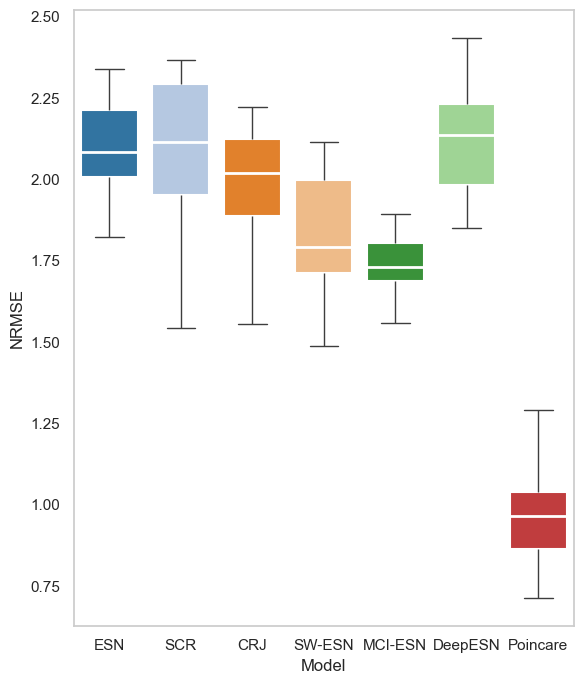

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", palette="muted")

target_horizon = 1000

records = []
for model_name in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'Poincare']:
    model_vals = [np.mean(entry[target_horizon]) for entry in nrmse_dict[model_name]]
    for val in model_vals:
        records.append({
            "Model": model_name,
            "NRMSE": val
        })

df = pd.DataFrame(records)

plt.figure(figsize=(6, 7))

sns.boxplot(
    x="Model",
    y="NRMSE",
    data=df,
    showfliers=False,
    palette=sns.color_palette("tab20", n_colors=df["Model"].nunique()),
    boxprops=dict(edgecolor="white", linewidth=1.5),
    medianprops=dict(color="white", linewidth=2)
)

plt.xlabel("Model")
plt.ylabel("NRMSE")
plt.grid(True, axis='y', linestyle='--', color='gray', alpha=0.0)
plt.gca().set_facecolor('white')

plt.tight_layout()
plt.savefig("Figures/Poincare_NRMSE_Boxplot_AR_Lorenz.png", dpi=600, bbox_inches='tight')
plt.show()


In [82]:
print(f"{'':<20} {'ESN':<20} {'SCR':<20} {'CRJ':<20} {'SW-ESN':<20} {'MCI-ESN':<20} {'Deep ESN':<20}  {'Poincare':<20}")
print("-" * 150)

print(f"{'T_VPT':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN',  'Poincare']:
    mean = np.mean(VPT_dict[model])
    std = np.std(VPT_dict[model])
    print(f"{mean:.3f} ± {std:.3f}".ljust(20), end='')
print()

print(f"{'T_VPT/T_lambda':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN',  'Poincare']:
    mean = np.mean(VPT_ratio_dict[model])
    std = np.std(VPT_ratio_dict[model])
    print(f"{mean:.3f} ± {std:.3f}".ljust(20), end='')
print()


                     ESN                  SCR                  CRJ                  SW-ESN               MCI-ESN              Deep ESN              Poincare            
------------------------------------------------------------------------------------------------------------------------------------------------------
T_VPT               3.867 ± 1.729       4.812 ± 1.846       6.113 ± 1.870       6.983 ± 2.230       8.486 ± 1.437       3.831 ± 1.382       16.719 ± 0.944      
T_VPT/T_lambda      3.499 ± 1.565       4.355 ± 1.670       5.532 ± 1.692       6.319 ± 2.018       7.680 ± 1.300       3.467 ± 1.251       15.130 ± 0.854      


C:\Users\ashut\AppData\Local\Temp\ipykernel_32884\2082158106.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Dark2_r', len(model_names))  # You can choose 'tab10', 'Set1', etc.


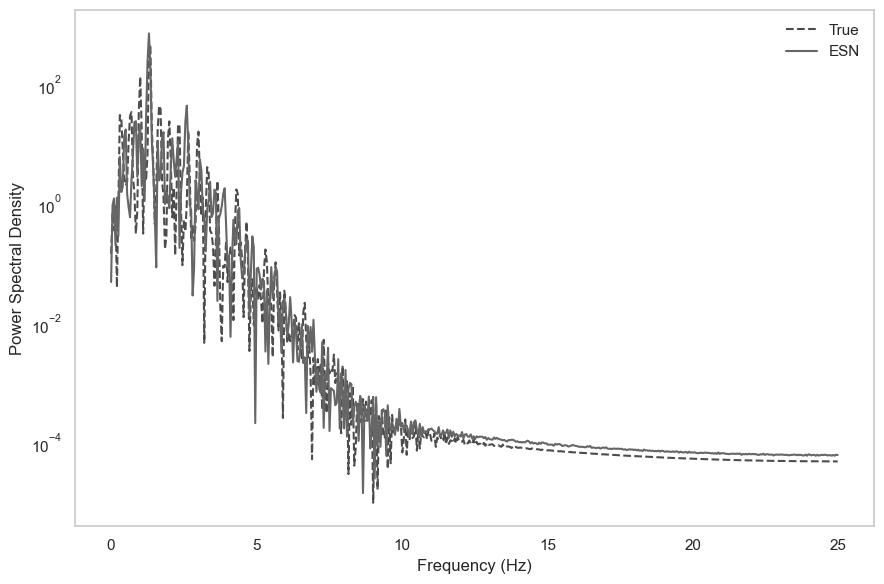

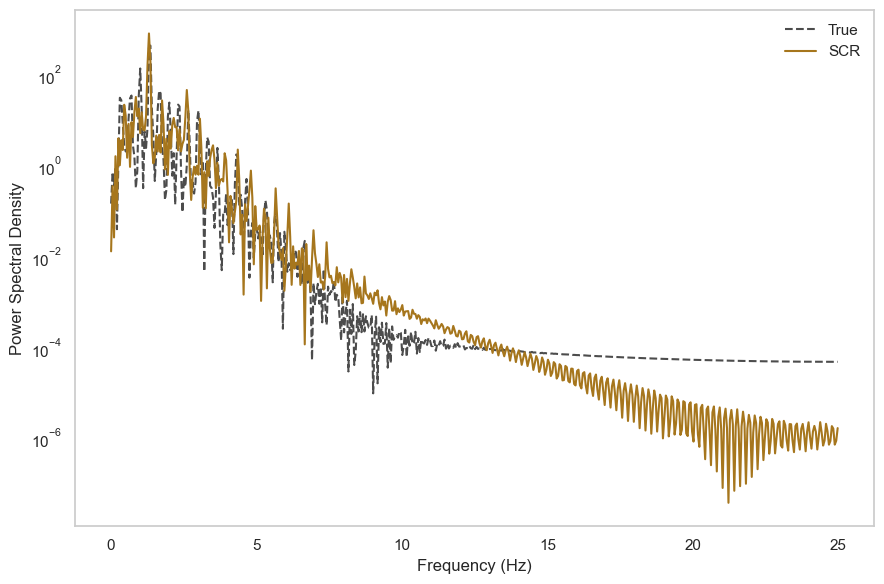

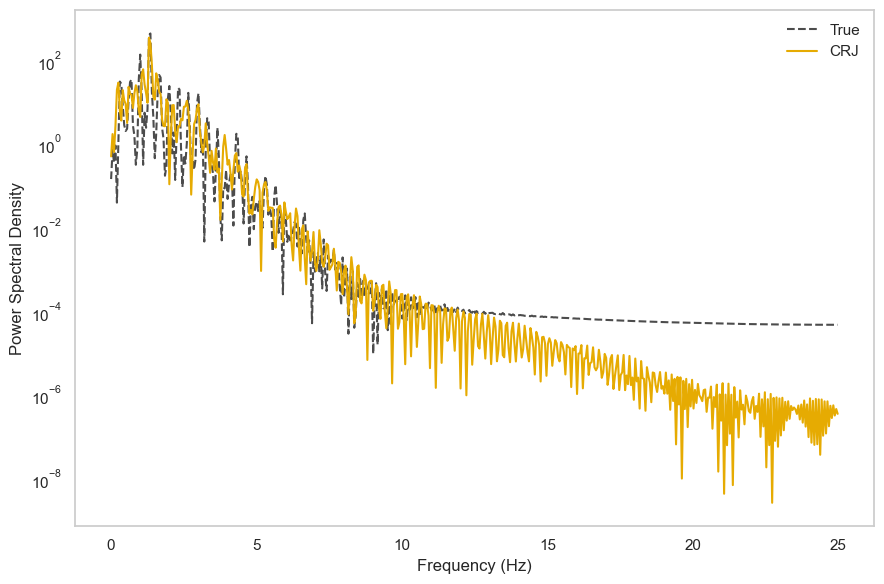

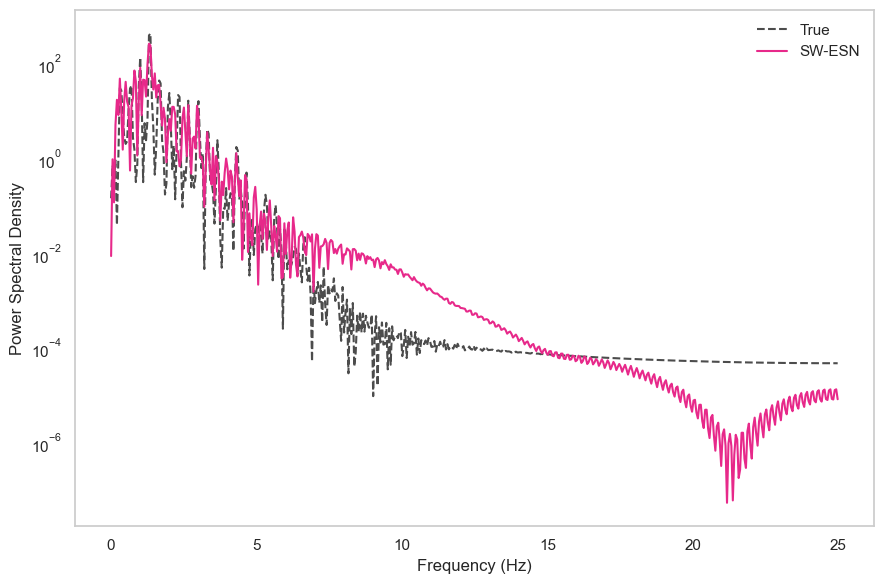

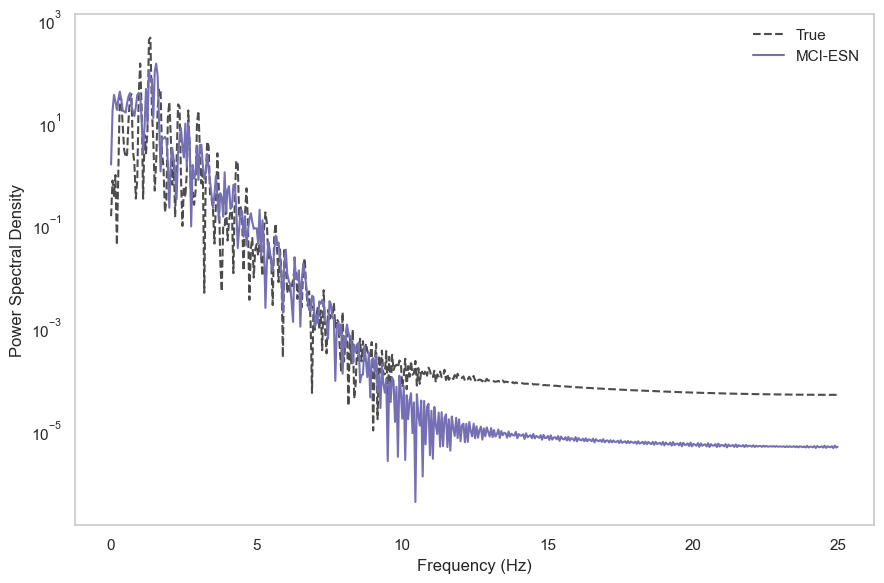

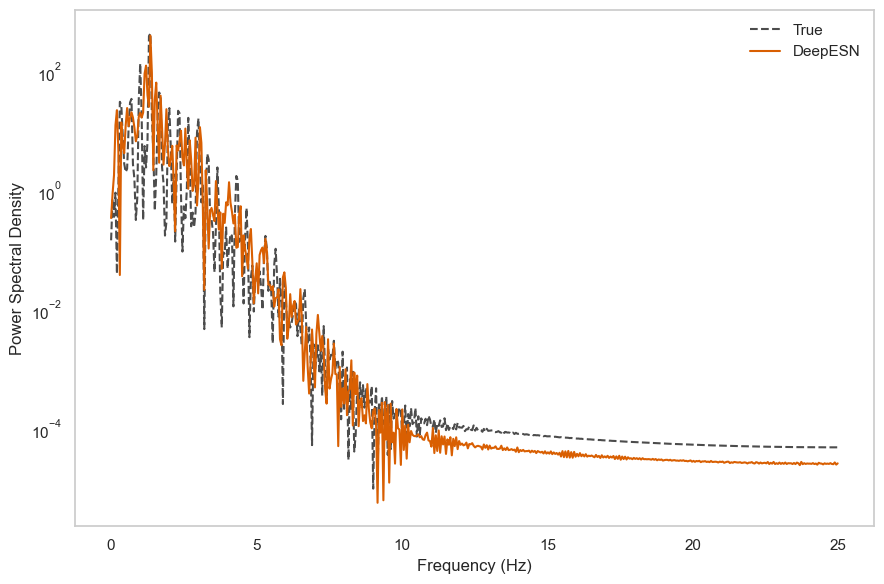

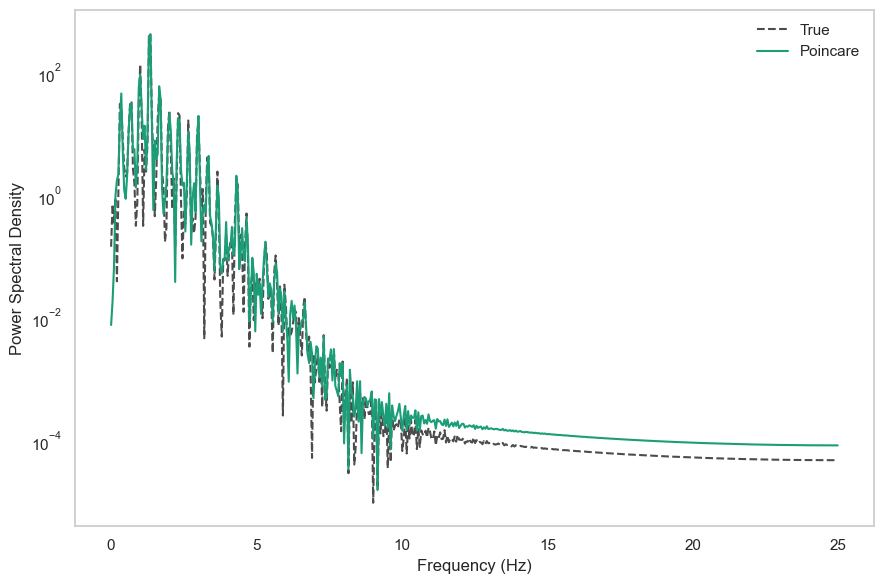

In [85]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Ensure output directory exists
os.makedirs("Figures/psr", exist_ok=True)

# Compute PSDs (correct order)
esn_freqs, esn_psd = compute_psd(esn_preds, dt=dt)
cycle_res_freqs, cycle_res_psd = compute_psd(cycle_res_preds, dt=dt)
crj_freqs, crj_psd = compute_psd(crj_preds, dt=dt)
sw_esn_freqs, sw_esn_psd = compute_psd(sw_esn_preds, dt=dt)
mci_esn_freqs, mci_esn_psd = compute_psd(mci_esn_preds, dt=dt)
deepesn_freqs, deepesn_psd = compute_psd(deepesn_preds, dt=dt)
psec_freqs, psec_psd = compute_psd(psec_preds, dt=dt)
target_freqs, target_psd = compute_psd(test_target, dt=dt)

# Apply frequency mask
mask = target_freqs <= 75

# Model info
model_names = ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'Poincare']
model_psds = [esn_psd, cycle_res_psd, crj_psd, sw_esn_psd, mci_esn_psd, deepesn_psd, psec_psd]
model_freqs = [esn_freqs, cycle_res_freqs, crj_freqs, sw_esn_freqs, mci_esn_freqs, deepesn_freqs, psec_freqs]

# Use matplotlib colormap for consistent model colors
cmap = cm.get_cmap('Dark2_r', len(model_names))  # You can choose 'tab10', 'Set1', etc.

# Plot each model vs True
for i, (name, psd, freqs) in enumerate(zip(model_names, model_psds, model_freqs)):
    plt.figure(figsize=(9, 6))

    # Fixed color for True target
    plt.semilogy(target_freqs[mask], target_psd[mask], label='True', linewidth=1.5, color='black', linestyle='--', alpha=0.7)
    
    # Color from colormap for model
    model_color = cmap(i)
    plt.semilogy(freqs[mask], psd[mask], label=name, linewidth=1.5, color=model_color)
    
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Power Spectral Density', fontsize=12)
    plt.legend(fontsize=11, frameon=False)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.0)
    plt.tight_layout()
    
    plt.savefig(f"Figures/psr/PSD_vs_Frequency_{name}_lorenz.png", dpi=600, bbox_inches='tight')
    plt.show()


## Experiments on Lorenz Dataset in Teacher-forced setting

In [36]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]


nrmse_dict = defaultdict(list)
seeds = range(1, 31)

In [37]:
for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.99,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)

In [38]:
for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-4,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)

In [39]:
for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=10,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-4,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

In [40]:
for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.3,
        degree=2,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-5,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.predict(test_input)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)

In [41]:
for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.03,
        v2=0.03,
        spectral_radius=0.8,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)

In [42]:
for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        connectivity=1.0,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)


In [ ]:
nrmse_dict['Poincare'] = []

for seed in seeds:
    psec = PoincareSectionRes3D(
            normal_vec=np.array([1, 0, 3]),
            delta=25, # 25
            M=250, # strategically taken as half the size of baselines
            spectral_radius=0.1, # 0.95
            input_scale=0.1,
            leaking_rate=0.2,
            ridge_alpha=1e-13,
            seed=seed
        )

    psec.fit_readout(train_input, train_target, discard=100)
    psec_preds = psec.predict(test_input)
    psec_nrmse = evaluate_nrmse(psec_preds, test_target, all_horizons)
    nrmse_dict['Poincare'].append(psec_nrmse)


In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW-ESN':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'PSR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    poincare_vals = [np.mean(poincare_nrmse[horizon]) for poincare_nrmse in nrmse_dict['Poincare']]

    print(f"&{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals, poincare_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"&{mean*1000:.6f} ± {std*1000:.6f}".ljust(25), end="")
    print()

## Experiments on Rossler Dataset under Autoregressive Forecasting

In [33]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_rossler = 0.071
lyapunov_time_rossler = 1.0 / lle_rossler
lyapunov_time = lyapunov_time_rossler
VPT_threshold = 0.5
test_time = np.arange(test_size)*dt
cube_size = (2, 2, 2)
seeds = range(1, 31)


nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

In [34]:
nrmse_dict['ESN'] = []
VPT_dict['ESN'] = []
VPT_ratio_dict['ESN'] = []
adev_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.85,
        connectivity=0.001,
        input_scale=0.05,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.autoregressive_predict(initial_input, num_steps)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)
    esn_VPT, esn_VPT_ratio = compute_valid_prediction_time(test_target, esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['ESN'].append(esn_VPT)
    VPT_ratio_dict['ESN'].append(esn_VPT_ratio)
    esn_adev = compute_attractor_deviation(esn_preds, test_target, cube_size)
    adev_dict['ESN'].append(esn_adev)

In [35]:
nrmse_dict['SCR'] = []
VPT_dict['SCR'] = []
VPT_ratio_dict['SCR'] = []
adev_dict['SCR'] = []


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.001,
        spectral_radius=0.6,
        input_scale=0.01,
        leaking_rate=0.6,
        ridge_alpha=1e-5,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.autoregressive_predict(initial_input, num_steps)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)
    cycle_res_VPT, cycle_res_VPT_ratio = compute_valid_prediction_time(test_target, cycle_res_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SCR'].append(cycle_res_VPT)
    VPT_ratio_dict['SCR'].append(cycle_res_VPT_ratio)
    cycle_res_adev = compute_attractor_deviation(cycle_res_preds, test_target, cube_size)
    adev_dict['SCR'].append(cycle_res_adev)

In [36]:
nrmse_dict['CRJ'] = []
VPT_dict['CRJ'] = []
VPT_ratio_dict['CRJ'] = []
adev_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.001,
        jump=5,
        spectral_radius=0.6,
        input_scale=0.01,
        leaking_rate=0.6,
        ridge_alpha=1e-5,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.autoregressive_predict(initial_input, num_steps)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)
    crj_VPT, crj_VPT_ratio = compute_valid_prediction_time(test_target, crj_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['CRJ'].append(crj_VPT)
    VPT_ratio_dict['CRJ'].append(crj_VPT_ratio)
    crj_adev = compute_attractor_deviation(crj_preds, test_target, cube_size)
    adev_dict['CRJ'].append(crj_adev)

In [37]:
nrmse_dict['SW-ESN'] = []
VPT_dict['SW-ESN'] = []
VPT_ratio_dict['SW-ESN'] = []
adev_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.005,
        degree=3,
        spectral_radius=0.6,
        input_scale=0.01,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.autoregressive_predict(initial_input, num_steps)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)
    sw_esn_VPT, sw_esn_VPT_ratio = compute_valid_prediction_time(test_target, sw_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SW-ESN'].append(sw_esn_VPT)
    VPT_ratio_dict['SW-ESN'].append(sw_esn_VPT_ratio)
    sw_esn_adev = compute_attractor_deviation(sw_esn_preds, test_target, cube_size)
    adev_dict['SW-ESN'].append(sw_esn_adev)

In [38]:
nrmse_dict['MCI-ESN'] = []
VPT_dict['MCI-ESN'] = []
VPT_ratio_dict['MCI-ESN'] = []
adev_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.3,
        combine_factor=0.5,
        v1=0.05,
        v2=0.05,
        spectral_radius=0.85,
        leaking_rate=0.9,
        ridge_alpha=1e-5,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.autoregressive_predict(initial_input, num_steps)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)
    mci_esn_VPT, mci_esn_VPT_ratio = compute_valid_prediction_time(test_target, mci_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['MCI-ESN'].append(mci_esn_VPT)
    VPT_ratio_dict['MCI-ESN'].append(mci_esn_VPT_ratio)
    mci_esn_adev = compute_attractor_deviation(mci_esn_preds, test_target, cube_size)
    adev_dict['MCI-ESN'].append(mci_esn_adev)


In [39]:
nrmse_dict['DeepESN'] = []
VPT_dict['DeepESN'] = []
VPT_ratio_dict['DeepESN'] = []
adev_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.85,
        connectivity=0.0005,
        input_scale=0.05,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.autoregressive_predict(initial_input, num_steps)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)
    deepesn_VPT, deepesn_VPT_ratio = compute_valid_prediction_time(test_target, deepesn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['DeepESN'].append(deepesn_VPT)
    VPT_ratio_dict['DeepESN'].append(deepesn_VPT_ratio)
    deepesn_adev = compute_attractor_deviation(deepesn_preds, test_target, cube_size)
    adev_dict['DeepESN'].append(deepesn_adev)

In [ ]:
nrmse_dict['Poincare'] = []
VPT_dict['Poincare'] = []
VPT_ratio_dict['Poincare'] = []
adev_dict['Poincare'] = []
cube_size = (2, 2, 2)

for seed in seeds:
    psec = PoincareSectionRes3D(
            normal_vec=np.array([-0.12145994, -0.0341516, 0.99200864]),
            delta=0.352, # 25
            M=75, # strategically taken as half the size of baselines
            spectral_radius=0.1, # 0.95
            input_scale=0.1,
            leaking_rate=0.1,
            ridge_alpha=1e-8,
            seed=seed
        )

    psec.fit_readout(train_input, train_target, discard=100)
    psec_preds = psec.autoregressive_predict(initial_input, num_steps)
    psec_nrmse = evaluate_nrmse(psec_preds, test_target, all_horizons)
    nrmse_dict['Poincare'].append(psec_nrmse)
    psec_VPT, psec_VPT_ratio = compute_valid_prediction_time(test_target, psec_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['Poincare'].append(psec_VPT)
    VPT_ratio_dict['Poincare'].append(psec_VPT_ratio)
    psec_adev = compute_attractor_deviation(psec_preds, test_target, cube_size)
    adev_dict['Poincare'].append(psec_adev)
    


In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 150)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW-ESN':<17} {'MCI-ESN':<17} {'DeepESN':<17}  {'Poincare':<17}")
print("-" * 150)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    psec_vals = [np.mean(psec_nrmse[horizon]) for psec_nrmse in nrmse_dict['Poincare']]

    print(f"& {horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals, psec_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"& {mean:.6f} ± {std:.6f}".ljust(25), end="")
    print()

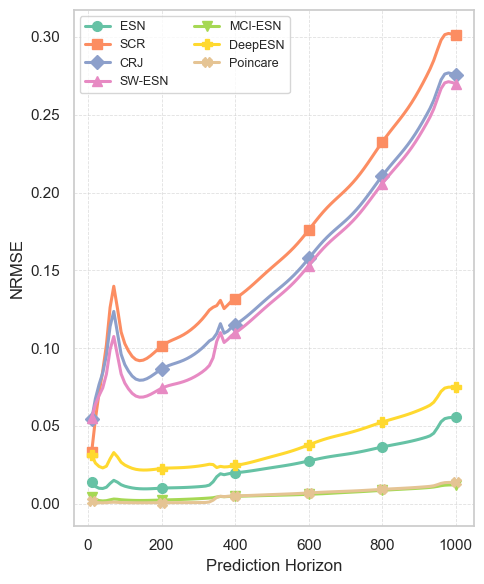

In [59]:
plot_len = 1000
steps = list(range(10, plot_len + 1, 10))
marker_steps = [10, 200, 400, 600, 800, 1000]

models = {
    'ESN': esn_nrmse,
    'SCR': cycle_res_nrmse,
    'CRJ': crj_nrmse,
    'SW-ESN': sw_esn_nrmse,
    'MCI-ESN': mci_esn_nrmse,
    'DeepESN': deepesn_nrmse,
    'Poincare': psec_nrmse
}

# Assign a unique marker and color style for each
# Use a different colormap for more variety
colors = plt.cm.Set2.colors  # Set2 has 8 distinct pastel colors
markers = ['o', 's', 'D', '^', 'v', 'P', 'X']

plt.figure(figsize=(5, 6))

for i, (name, data) in enumerate(models.items()):
    values = [np.mean(data[s]) for s in steps]
    color = colors[i % len(colors)]
    marker = markers[i % len(markers)]
    values = []

    for horizon in all_horizons:
        # Get all NRMSE values across all runs for this model and this horizon
        all_vals = []
        for run in nrmse_dict[name]:
            all_vals.extend([np.mean(run[horizon])])
        values.append(np.mean(all_vals))

    # Plot with markers so legend also shows them
    plt.plot(steps, values, label=name, linewidth=2.2, color=color,
             marker=marker, markevery=[steps.index(s) for s in marker_steps if s in steps],
             markersize=7)

# Labels and title
plt.xlabel('Prediction Horizon', fontsize=12)
plt.ylabel('NRMSE', fontsize=12)
# plt.title('NRMSE vs. Prediction Horizon (Autoregressive Forecasting)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
plt.legend(fontsize=9, ncol=2, loc='upper left')
plt.tight_layout()
plt.savefig("Figures/Poincare_NRMSE_vs_Prediction_Horizon_AR_Rossler.png", dpi=600, bbox_inches='tight')
plt.show()

C:\Users\ashut\AppData\Local\Temp\ipykernel_18032\1873431914.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


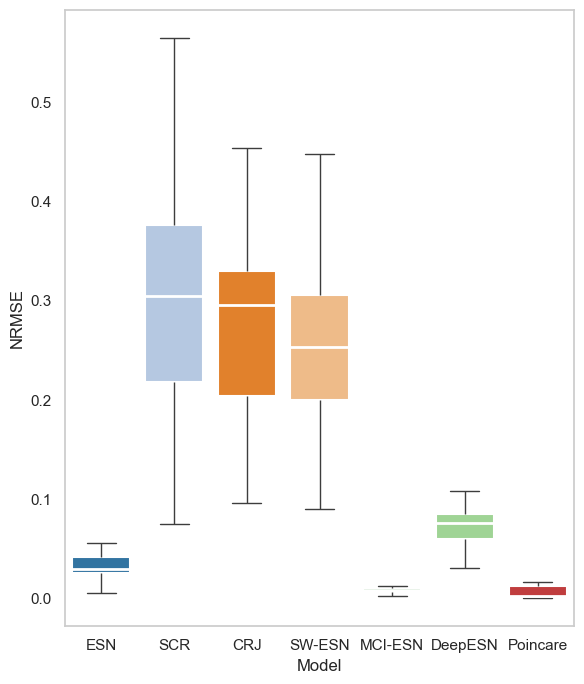

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", palette="muted")

target_horizon = 1000

records = []
for model_name in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'Poincare']:
    model_vals = [np.mean(entry[target_horizon]) for entry in nrmse_dict[model_name]]
    for val in model_vals:
        records.append({
            "Model": model_name,
            "NRMSE": val
        })

df = pd.DataFrame(records)

plt.figure(figsize=(6, 7))

sns.boxplot(
    x="Model",
    y="NRMSE",
    data=df,
    showfliers=False,
    palette=sns.color_palette("tab20", n_colors=df["Model"].nunique()),
    boxprops=dict(edgecolor="white", linewidth=1.5),
    medianprops=dict(color="white", linewidth=2)
)

plt.xlabel("Model")
plt.ylabel("NRMSE")
plt.grid(True, axis='y', linestyle='--', color='gray', alpha=0.0)
plt.gca().set_facecolor('white')

plt.tight_layout()
plt.savefig("Figures/Poincare_NRMSE_Boxplot_AR_Rossler.png", dpi=600, bbox_inches='tight')
plt.show()


In [61]:
print(f"{'':<20} {'ESN':<20} {'SCR':<20} {'CRJ':<20} {'SW-ESN':<20} {'MCI-ESN':<20} {'Deep ESN':<20}  {'Poincare':<20}")
print("-" * 150)

print(f"{'T_VPT':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN',  'Poincare']:
    mean = np.mean(VPT_dict[model])
    std = np.std(VPT_dict[model])
    print(f"{mean:.3f} ± {std:.3f}".ljust(20), end='')
print()

print(f"{'T_VPT/T_lambda':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN',  'Poincare']:
    mean = np.mean(VPT_ratio_dict[model])
    std = np.std(VPT_ratio_dict[model])
    print(f"{mean:.3f} ± {std:.3f}".ljust(20), end='')
print()


                     ESN                  SCR                  CRJ                  SW-ESN               MCI-ESN              Deep ESN              Poincare            
------------------------------------------------------------------------------------------------------------------------------------------------------
T_VPT               77.959 ± 30.120     48.195 ± 27.924     42.468 ± 26.461     39.329 ± 28.028     86.878 ± 20.573     94.810 ± 37.759     105.818 ± 33.355    
T_VPT/T_lambda      5.535 ± 2.139       3.422 ± 1.983       3.015 ± 1.879       2.792 ± 1.990       6.168 ± 1.461       6.732 ± 2.681       7.513 ± 2.368       


## Experiments on Rossler Dataset in Teacher-Forced Setting

In [64]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)

In [65]:
nrmse_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.85,
        connectivity=0.001,
        input_scale=0.05,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)

In [66]:
nrmse_dict['SCR'] = []

for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.001,
        spectral_radius=0.6,
        input_scale=0.01,
        leaking_rate=0.6,
        ridge_alpha=1e-5,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)

In [67]:
nrmse_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.001,
        jump=5,
        spectral_radius=0.6,
        input_scale=0.01,
        leaking_rate=0.6,
        ridge_alpha=1e-5,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

In [68]:
nrmse_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.005,
        degree=3,
        spectral_radius=0.6,
        input_scale=0.01,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.predict(test_input)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)

In [69]:
nrmse_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.3,
        combine_factor=0.5,
        v1=0.05,
        v2=0.05,
        spectral_radius=0.85,
        leaking_rate=0.9,
        ridge_alpha=1e-5,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)

In [70]:
nrmse_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.85,
        connectivity=0.00005,
        input_scale=0.05,
        leaking_rate=0.8,
        ridge_alpha=1e-4,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW-ESN':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'PSR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    poincare_vals = [np.mean(poincare_nrmse[horizon]) for poincare_nrmse in nrmse_dict['Poincare']]

    print(f"&{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals, poincare_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"&{mean*1000:.6f} ± {std*1000:.6f}".ljust(25), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW-ESN            MCI-ESN           DeepESN           PSR              
--------------------------------------------------------------------------------------------------------------------------------------------
&200        &0.063438 ± 0.014301     &0.174991 ± 0.015364     &0.246187 ± 0.018351     &0.194090 ± 0.023311     &0.029253 ± 0.003113     &0.401805 ± 0.033282     &0.033560 ± 0.006582     
&400        &0.033494 ± 0.005548     &0.099341 ± 0.005383     &0.121694 ± 0.006949     &0.101397 ± 0.007495     &0.015426 ± 0.001093     &0.210192 ± 0.017597     &0.015218 ± 0.002640     
&600        &0.038894 ± 0.009121     &0.098227 ± 0.005483     &0.120742 ± 0.006909     &0.100424 ± 0.007445     &0.015892 ± 0.001150     &0.222996 ± 0.015884     &

## Experiments on Chen Dataset under Autoregressive Forecasting

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_chen = 0.830
lyapunov_time_chen = 1.0 / lle_chen
lyapunov_time = lyapunov_time_chen
VPT_threshold = 0.3
test_time = np.arange(test_size)*dt
cube_size = (4, 4, 4)
seeds = range(1, 31)


nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

In [ ]:
nrmse_dict['ESN'] = []
VPT_dict['ESN'] = []
VPT_ratio_dict['ESN'] = []
adev_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.99,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-3,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.autoregressive_predict(initial_input, num_steps)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)
    esn_VPT, esn_VPT_ratio = compute_valid_prediction_time(test_target, esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['ESN'].append(esn_VPT)
    VPT_ratio_dict['ESN'].append(esn_VPT_ratio)
    esn_adev = compute_attractor_deviation(esn_preds, test_target, cube_size)
    adev_dict['ESN'].append(esn_adev)

In [ ]:
nrmse_dict['SCR'] = []
VPT_dict['SCR'] = []
VPT_ratio_dict['SCR'] = []
adev_dict['SCR'] = []

for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-2,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.autoregressive_predict(initial_input, num_steps)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)
    cycle_res_VPT, cycle_res_VPT_ratio = compute_valid_prediction_time(test_target, cycle_res_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SCR'].append(cycle_res_VPT)
    VPT_ratio_dict['SCR'].append(cycle_res_VPT_ratio)
    cycle_res_adev = compute_attractor_deviation(cycle_res_preds, test_target, cube_size)
    adev_dict['SCR'].append(cycle_res_adev)

In [ ]:
nrmse_dict['CRJ'] = []
VPT_dict['CRJ'] = []
VPT_ratio_dict['CRJ'] = []
adev_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=10,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-2,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.autoregressive_predict(initial_input, num_steps)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)
    crj_VPT, crj_VPT_ratio = compute_valid_prediction_time(test_target, crj_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['CRJ'].append(crj_VPT)
    VPT_ratio_dict['CRJ'].append(crj_VPT_ratio)
    crj_adev = compute_attractor_deviation(crj_preds, test_target, cube_size)
    adev_dict['CRJ'].append(crj_adev)

In [ ]:
nrmse_dict['SW-ESN'] = []
VPT_dict['SW-ESN'] = []
VPT_ratio_dict['SW-ESN'] = []
adev_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.3,
        degree=2,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-3,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.autoregressive_predict(initial_input, num_steps)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)
    sw_esn_VPT, sw_esn_VPT_ratio = compute_valid_prediction_time(test_target, sw_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SW-ESN'].append(sw_esn_VPT)
    VPT_ratio_dict['SW-ESN'].append(sw_esn_VPT_ratio)
    sw_esn_adev = compute_attractor_deviation(sw_esn_preds, test_target, cube_size)
    adev_dict['SW-ESN'].append(sw_esn_adev)

In [ ]:
nrmse_dict['MCI-ESN'] = []
VPT_dict['MCI-ESN'] = []
VPT_ratio_dict['MCI-ESN'] = []
adev_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.03,
        v2=0.03,
        spectral_radius=0.8,
        leaking_rate=0.8,
        ridge_alpha=1e-3,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.autoregressive_predict(initial_input, num_steps)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)
    mci_esn_VPT, mci_esn_VPT_ratio = compute_valid_prediction_time(test_target, mci_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['MCI-ESN'].append(mci_esn_VPT)
    VPT_ratio_dict['MCI-ESN'].append(mci_esn_VPT_ratio)
    mci_esn_adev = compute_attractor_deviation(mci_esn_preds, test_target, cube_size)
    adev_dict['MCI-ESN'].append(mci_esn_adev)

In [ ]:
nrmse_dict['DeepESN'] = []
VPT_dict['DeepESN'] = []
VPT_ratio_dict['DeepESN'] = []
adev_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        connectivity=1.0,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-3,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.autoregressive_predict(initial_input, num_steps)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)
    deepesn_VPT, deepesn_VPT_ratio = compute_valid_prediction_time(test_target, deepesn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['DeepESN'].append(deepesn_VPT)
    VPT_ratio_dict['DeepESN'].append(deepesn_VPT_ratio)
    deepesn_adev = compute_attractor_deviation(deepesn_preds, test_target, cube_size)
    adev_dict['DeepESN'].append(deepesn_adev)

In [ ]:
nrmse_dict['Poincare'] = []
VPT_dict['Poincare'] = []
VPT_ratio_dict['Poincare'] = []
adev_dict['Poincare'] = []

for seed in seeds:
    psec = PoincareSectionRes3D(
            normal_vec=np.array([ 0.57817882, -0.64943894,  0.49390113]),
            delta=12.362867895770227, # 25
            M=250, # strategically taken as half the size of baselines
            spectral_radius=0.1, # 0.95
            input_scale=0.1,
            leaking_rate=0.2,
            ridge_alpha=1e-13,
            seed=seed
        )

    psec.fit_readout(train_input, train_target, discard=100)
    psec_preds = psec.autoregressive_predict(initial_input, num_steps)
    psec_nrmse = evaluate_nrmse(psec_preds, test_target, all_horizons)
    nrmse_dict['Poincare'].append(psec_nrmse)
    psec_VPT, psec_VPT_ratio = compute_valid_prediction_time(test_target, psec_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['Poincare'].append(psec_VPT)
    VPT_ratio_dict['Poincare'].append(psec_VPT_ratio)
    psec_adev = compute_attractor_deviation(psec_preds, test_target, cube_size)
    adev_dict['Poincare'].append(psec_adev)


In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 150)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW-ESN':<17} {'MCI-ESN':<17} {'DeepESN':<17}  {'Poincare':<17}")
print("-" * 150)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    psec_vals = [np.mean(psec_nrmse[horizon]) for psec_nrmse in nrmse_dict['Poincare']]

    print(f"& {horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals,  psec_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"& {mean:.6f} ± {std:.6f}".ljust(25), end="")
    print()

In [ ]:
print(f"{'':<20} {'ESN':<20} {'SCR':<20} {'CRJ':<20} {'SW-ESN':<20} {'MCI-ESN':<20} {'Deep ESN':<20}  {'Poincare':<20}")
print("-" * 150)

print(f"{'T_VPT':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN',  'Poincare']:
    mean = np.mean(VPT_dict[model])
    std = np.std(VPT_dict[model])
    print(f"{mean:.3f} ± {std:.3f}".ljust(20), end='')
print()

print(f"{'T_VPT/T_lambda':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN',  'Poincare']:
    mean = np.mean(VPT_ratio_dict[model])
    std = np.std(VPT_ratio_dict[model])
    print(f"{mean:.3f} ± {std:.3f}".ljust(20), end='')
print()


In [ ]:
print(f"{'':<20} {'ESN':<20} {'SCR':<20} {'CRJ':<20} {'SW-ESN':<20} {'MCI-ESN':<20}  {'Poincare':<20}")
print("-" * 170)

print(f"{'ADev':<20}", end='')
for model in ['ESN', 'SCR', 'CRJ', 'SW-ESN', 'MCI-ESN', 'DeepESN', 'Poincare']:
    values = adev_dict[model]
    mean = np.mean(values)
    mad = np.mean(np.abs(values - mean))
    print(f"{mean:.3f} ± {mad:.3f}".ljust(20), end='')
print()

## Experiments on Chen Dataset in Teacher-Forced Setting

In [ ]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]

nrmse_dict = defaultdict(list)
seeds = range(1, 31)

In [ ]:
nrmse_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.99,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-9,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)

In [ ]:
nrmse_dict['SCR'] = []

for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-9,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)

In [ ]:
nrmse_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=10,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-9,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

In [ ]:
nrmse_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.3,
        degree=2,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-9,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.predict(test_input)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)

In [ ]:
nrmse_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.03,
        v2=0.03,
        spectral_radius=0.8,
        leaking_rate=0.8,
        ridge_alpha=1e-9,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)

In [ ]:
nrmse_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        connectivity=1.0,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-9,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

In [ ]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW-ESN':<17} {'MCI-ESN':<17} {'DeepESN':<17} {'PSR':<17}")
print("-" * 140)


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals  = [np.mean(sw_esn_nrmse[horizon]) for sw_esn_nrmse in nrmse_dict['SW-ESN']]
    mci_vals = [np.mean(mci_esn_nrmse[horizon]) for mci_esn_nrmse in nrmse_dict['MCI-ESN']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    psec_vals = [np.mean(psec_nrmse[horizon]) for psec_nrmse in nrmse_dict['Poincare']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, mci_vals, deep_vals, psec_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean*1000:.6f} ± {std*1000:.6f}".ljust(18), end="")
    print()

## Experiments on Chua Dataset in Teacher-Forced Setting

In [89]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]

nrmse_dict = defaultdict(list)
seeds = range(1, 31)

In [ ]:
nrmse_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.6,
        connectivity=0.3,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)

In [ ]:
nrmse_dict['SCR'] = []

for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.7,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-5,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)

In [ ]:
nrmse_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.7,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-5,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

In [ ]:
nrmse_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.3,
        degree=2,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-5,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.predict(test_input)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)

In [ ]:
nrmse_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.08,
        v2=0.08,
        spectral_radius=0.99,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.predict(test_input)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)

In [ ]:
nrmse_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        connectivity=0.5,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-5,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

In [ ]:
nrmse_dict['Poincare'] = []

for seed in seeds:
    psec = PoincareSectionRes3D(
            normal_vec=np.array([0.39947424, -0.86592628,  0.30098507]),
            delta=0.009026547234254723, # 25
            M=250, # strategically taken as half the size of baselines
            spectral_radius=0.1, # 0.95
            input_scale=0.1,
            leaking_rate=0.2,
            ridge_alpha=1e-13,
            seed=seed
        )

    psec.fit_readout(train_input, train_target, discard=100)
    psec_preds = psec.predict(test_input)
    psec_nrmse = evaluate_nrmse(psec_preds, test_target, all_horizons)
    nrmse_dict['Poincare'].append(psec_nrmse)


## Experiments on Chua Dataset in Autoregressive Setting

In [85]:
all_horizons = list(range(10, 1001, 10))
horizons = [200, 400, 600, 800, 1000]
initial_input = test_input[0]
num_steps = len(test_input)
lle_chua = 0.158
lyapunov_time_chua = 1.0 / lle_chua
lyapunov_time = lyapunov_time_chua
VPT_threshold = 0.4
test_time = np.arange(test_size)*dt
cube_size = (2, 2, 2)
seeds = range(1, 31)


nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

In [ ]:
nrmse_dict['ESN'] = []
VPT_dict['ESN'] = []
VPT_ratio_dict['ESN'] = []
adev_dict['ESN'] = []

for seed in seeds:
    esn = BaselineESN3D(
        reservoir_size=300,
        spectral_radius=0.99,
        connectivity=0.05,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-3,
        seed=seed
    )
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.autoregressive_predict(initial_input, num_steps)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)
    esn_VPT, esn_VPT_ratio = compute_valid_prediction_time(test_target, esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['ESN'].append(esn_VPT)
    VPT_ratio_dict['ESN'].append(esn_VPT_ratio)
    esn_adev = compute_attractor_deviation(esn_preds, test_target, cube_size)
    adev_dict['ESN'].append(esn_adev)

In [ ]:
nrmse_dict['SCR'] = []
VPT_dict['SCR'] = []
VPT_ratio_dict['SCR'] = []
adev_dict['SCR'] = []

for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        cycle_weight=0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-2,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.autoregressive_predict(initial_input, num_steps)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)
    cycle_res_VPT, cycle_res_VPT_ratio = compute_valid_prediction_time(test_target, cycle_res_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SCR'].append(cycle_res_VPT)
    VPT_ratio_dict['SCR'].append(cycle_res_VPT_ratio)
    cycle_res_adev = compute_attractor_deviation(cycle_res_preds, test_target, cube_size)
    adev_dict['SCR'].append(cycle_res_adev)

In [ ]:
nrmse_dict['CRJ'] = []
VPT_dict['CRJ'] = []
VPT_ratio_dict['CRJ'] = []
adev_dict['CRJ'] = []

for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=10,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-2,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.autoregressive_predict(initial_input, num_steps)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)
    crj_VPT, crj_VPT_ratio = compute_valid_prediction_time(test_target, crj_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['CRJ'].append(crj_VPT)
    VPT_ratio_dict['CRJ'].append(crj_VPT_ratio)
    crj_adev = compute_attractor_deviation(crj_preds, test_target, cube_size)
    adev_dict['CRJ'].append(crj_adev)

In [ ]:
nrmse_dict['SW-ESN'] = []
VPT_dict['SW-ESN'] = []
VPT_ratio_dict['SW-ESN'] = []
adev_dict['SW-ESN'] = []

for seed in seeds:
    sw_esn = SWRes3D(
        reservoir_size=300,
        rewiring_prob=0.3,
        degree=2,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.7,
        ridge_alpha=1e-3,
        seed=seed
    )
    sw_esn.fit_readout(train_input, train_target, discard=100)
    sw_esn_preds = sw_esn.autoregressive_predict(initial_input, num_steps)
    sw_esn_nrmse = evaluate_nrmse(sw_esn_preds, test_target, all_horizons)
    nrmse_dict['SW-ESN'].append(sw_esn_nrmse)
    sw_esn_VPT, sw_esn_VPT_ratio = compute_valid_prediction_time(test_target, sw_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['SW-ESN'].append(sw_esn_VPT)
    VPT_ratio_dict['SW-ESN'].append(sw_esn_VPT_ratio)
    sw_esn_adev = compute_attractor_deviation(sw_esn_preds, test_target, cube_size)
    adev_dict['SW-ESN'].append(sw_esn_adev)

In [ ]:
nrmse_dict['MCI-ESN'] = []
VPT_dict['MCI-ESN'] = []
VPT_ratio_dict['MCI-ESN'] = []
adev_dict['MCI-ESN'] = []

for seed in seeds:
    mci_esn = MCIESN3D(
        reservoir_size=300,
        cycle_weight=0.8,
        connect_weight=0.8,
        combine_factor=0.1,
        v1=0.03,
        v2=0.03,
        spectral_radius=0.8,
        leaking_rate=0.8,
        ridge_alpha=1e-3,
        seed=seed
    )
    mci_esn.fit_readout(train_input, train_target, discard=100)
    mci_esn_preds = mci_esn.autoregressive_predict(initial_input, num_steps)
    mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, all_horizons)
    nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)
    mci_esn_VPT, mci_esn_VPT_ratio = compute_valid_prediction_time(test_target, mci_esn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['MCI-ESN'].append(mci_esn_VPT)
    VPT_ratio_dict['MCI-ESN'].append(mci_esn_VPT_ratio)
    mci_esn_adev = compute_attractor_deviation(mci_esn_preds, test_target, cube_size)
    adev_dict['MCI-ESN'].append(mci_esn_adev)

In [ ]:
nrmse_dict['DeepESN'] = []
VPT_dict['DeepESN'] = []
VPT_ratio_dict['DeepESN'] = []
adev_dict['DeepESN'] = []

for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        connectivity=1.0,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-3,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.autoregressive_predict(initial_input, num_steps)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)
    deepesn_VPT, deepesn_VPT_ratio = compute_valid_prediction_time(test_target, deepesn_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['DeepESN'].append(deepesn_VPT)
    VPT_ratio_dict['DeepESN'].append(deepesn_VPT_ratio)
    deepesn_adev = compute_attractor_deviation(deepesn_preds, test_target, cube_size)
    adev_dict['DeepESN'].append(deepesn_adev)

In [ ]:
nrmse_dict['Poincare'] = []
VPT_dict['Poincare'] = []
VPT_ratio_dict['Poincare'] = []
adev_dict['Poincare'] = []

for seed in seeds:
    psec = PoincareSectionRes3D(
            normal_vec=np.array([ 0.57817882, -0.64943894,  0.49390113]),
            delta=12.362867895770227, # 25
            M=250, # strategically taken as half the size of baselines
            spectral_radius=0.1, # 0.95
            input_scale=0.1,
            leaking_rate=0.2,
            ridge_alpha=1e-13,
            seed=seed
        )

    psec.fit_readout(train_input, train_target, discard=100)
    psec_preds = psec.autoregressive_predict(initial_input, num_steps)
    psec_nrmse = evaluate_nrmse(psec_preds, test_target, all_horizons)
    nrmse_dict['Poincare'].append(psec_nrmse)
    psec_VPT, psec_VPT_ratio = compute_valid_prediction_time(test_target, psec_preds, test_time, lyapunov_time, VPT_threshold)
    VPT_dict['Poincare'].append(psec_VPT)
    VPT_ratio_dict['Poincare'].append(psec_VPT_ratio)
    psec_adev = compute_attractor_deviation(psec_preds, test_target, cube_size)
    adev_dict['Poincare'].append(psec_adev)


## Plane Crossings


In [361]:
# `inputs` has shape (T, 3)   --------------  delay embedding
X = data - data.mean(axis=0, keepdims=True)
# principal directions of covariance
eigvals, eigvecs = np.linalg.eigh(np.cov(X.T))
# sort descending: eigvecs[:, -1] = largest λ, eigvecs[:, -2] = 2nd largest
v1 = eigvecs[:, -1]          # max-variance direction
v2 = eigvecs[:, -2]          # next variance direction

# plane normal  n  is orthogonal to (v1,v2)
normal_vec = np.cross(v1, v2)
normal_vec /= np.linalg.norm(normal_vec)
delta = normal_vec @ inputs.mean(axis=0)

def signed_dist(X, n, δ):
    return X @ n - δ

signs = np.sign(signed_dist(inputs, normal_vec, delta))
cross_idx = np.where(signs[:-1] * signs[1:] < 0)[0]   # sign changes

print(f"plane crossings found: {len(cross_idx)}")
print(normal_vec)
print(delta)

plane crossings found: 14341
[-0.41130897  0.81340386 -0.41133818]
-0.0018654712873994207
